# Goal is to maintain continuous derivatives in EOS
## - loop through eos to store all values
## - if value is discontinuous, take average of previous and following datapoint
## - t goes up to 181.9

### change EOS derivatives for T = 0.105
### take np.abs() for - derivatives close to 0
### loop over existing temps from logtemp and ye from ye

# Questions
## - what should the behavior of each variable look like?
## - 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
#from kuibit import timeseries as ts
#from kuibit import unitconv as uc
#from kuibit.simdir import SimDir
from matplotlib import rc
import scipy.constants as const
import scipy.integrate as integrate
from scipy.optimize import root as root
from scipy.special import sph_harm
import matplotlib
from matplotlib import rcParams
import pylab
import os
from scipy.interpolate import griddata
import h5py
from ConstantsAndConversions import *
from collections import OrderedDict
import scipy as sp
import os

%matplotlib inline

import numpy.ma as ma
#import cmasher as cmr
from matplotlib.pyplot import figure

rcParams.update({'figure.autolayout': True})
#matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family': 'serif', 'serif':['Computer Modern'], 'size':11})
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rcParams['xtick.minor.size'] = 1
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rc('legend', fontsize=20)

%matplotlib inline

/var/folders/nr/rbr3ndbn343d7__44zxt3v780000gn/T/ipykernel_62913/3940887045.py:31: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [8]:
def shorten_str(s,max_len=10):
    """Shorten string
    Shorten a string to make it easier to read when printed
    Args:
        s (str): string. Original text to be shortened
        max_len (int): integer. Maximum length of the string to return. Default = 10
    Returns:
        str: shortened string
    """
    if len(s) <= max_len:
        return s
    else:
        l = (max_len-3)//2
        return s[:l] + '...' + s[-1*l:]

def shorten_path(path,max_len=10):
    """ Shorten path string
    Shorten a path string to make it easier to read when printed
    Args:
        path (str): string. Original path to be shortened
        max_len (int): integer. Maximum length of each dir to return. Default = 10
    Returns:
        str: shortened path
    """
    components = path.split('/')
    filename = components[-1]
    dirs = components[:-1]
    if len(dirs) > 2:
        dirs = [dirs[0],'...',dirs[-1]]
    s = ''
    for dir in dirs:
        s = s + shorten_str(dir,max_len=max_len) + '/'
    s = s + shorten_str(filename,max_len=max_len)
    return s


def plot_EOS(filenames, ye, T=0.105,verbose=False, beta=False, dpderho_CO=[], dpdrhoe_CO=[], cs2_CO=[]):
    """Plot equation of state
    Plot the equation of state described by various .h5 files in the stellarcollapse format
    Args:
        filenames (array): list or array of strings. These are the paths to .h5 files to be plotted
        T (float): Temperature to plot at in MeV. Default = 0.1
        verbose (bool): Switch to turn on print statements during run
    Returns:
        plt.Figure: Figure to be plotted
        cs2: list of cs2 plotted
    """
    #make a figure of size 15,10 with 2 rows and 3 columns
    plt.style.use('seaborn-colorblind')

    fig, ax= plt.subplots(nrows=3, ncols=4,figsize=(11,7), tight_layout=True)
    #define the subplot for this figure, we are only doing one subplot for now
    #set the value of the line width and font size
    universal_linewidth=2
    universal_fontsize=11
    
    fig.suptitle(f"EOS Variables wrt restmass density for T={T} and Ye={ye}")
    if isinstance(filenames, str):
        filenames = [filenames]
    for filename_CO in filenames:
        f2 = h5py.File(filename_CO, 'r')

        keys2 = list(f2.keys())
        possible_varnames=['Abar','Xa','Xh','Xn','Xp','Zbar','cs2','dedt','dpderho','dpdrhoe','energy_shift','entropy',
                    'gamma','logenergy','logpress','logrho','logtemp','mu_e','mu_n','mu_p','muhat','munu',
                   'pointsrho','pointstemp','pointsye','ye']


        
        CO_EOS=[]
        for i in range(0, len(keys2)):
            if verbose:
                print("%d: %s" %(i, keys2[i]))
            CO_EOS.append(np.array(f2.get(keys2[i])))
        
        #Get the closest entry in the temperature that corresponds to 0.1 MeV
        T_target=T
        Ye_target=ye

        Tcold_index_CO=list(np.abs(10.**CO_EOS[keys2.index('logtemp')]-T_target)).index(np.min(np.abs(10.**CO_EOS[keys2.index('logtemp')] - T_target)))
        Ye_index_CO=list(np.abs(CO_EOS[keys2.index('ye')]-Ye_target)).index(np.min(np.abs(CO_EOS[keys2.index('ye')] - Ye_target)))
        print(np.abs(CO_EOS[keys2.index('ye')]-Ye_target))

        if verbose:
            print('Temp Index: ',Tcold_index_CO, '\nTempurature: ', 10.**CO_EOS[keys2.index('logtemp')][Tcold_index_CO])


        logRho_CO=[]
        Yebeta_CO=[]
        logPress_CO=[]
        logEnergy_CO=[]
        dedt_CO=[]
        #dpderho_CO=[]
        #dpdrhoe_CO=[]
        mu_e_CO=[]
        mu_n_CO=[]
        mu_p_CO=[]
        entropy_CO=[]
        #cs2_CO=[]
        
        if len(dpderho_CO)<2:
            for rho_index in range(0, len(CO_EOS[keys2.index('logrho')])):
                mu_betaCO = list(np.abs(CO_EOS[keys2.index('mu_n')][:,Tcold_index_CO,rho_index] - CO_EOS[keys2.index('mu_p')][:,Tcold_index_CO,rho_index] - CO_EOS[keys2.index('mu_e')][:,Tcold_index_CO,rho_index]))

                #beta-equilibrium corresponds to the closest value of mu_beta to zero, find the index
                if beta:
                    Ye_index_CO = list(mu_betaCO).index(np.min(mu_betaCO))
                    
                dpderho_CO.append(CO_EOS[keys2.index('dpderho')][Ye_index_CO][Tcold_index_CO][rho_index])
                
        if len(dpdrhoe_CO)<2:
            for rho_index in range(0, len(CO_EOS[keys2.index('logrho')])):
                mu_betaCO = list(np.abs(CO_EOS[keys2.index('mu_n')][:,Tcold_index_CO,rho_index] - CO_EOS[keys2.index('mu_p')][:,Tcold_index_CO,rho_index] - CO_EOS[keys2.index('mu_e')][:,Tcold_index_CO,rho_index]))

                #beta-equilibrium corresponds to the closest value of mu_beta to zero, find the index
                if beta:
                    Ye_index_CO = list(mu_betaCO).index(np.min(mu_betaCO))
                    
                dpdrhoe_CO.append(CO_EOS[keys2.index('dpdrhoe')][Ye_index_CO][Tcold_index_CO][rho_index])
                
        if len(cs2_CO)<2:
            for rho_index in range(0, len(CO_EOS[keys2.index('logrho')])):
                mu_betaCO = list(np.abs(CO_EOS[keys2.index('mu_n')][:,Tcold_index_CO,rho_index] - CO_EOS[keys2.index('mu_p')][:,Tcold_index_CO,rho_index] - CO_EOS[keys2.index('mu_e')][:,Tcold_index_CO,rho_index]))

                #beta-equilibrium corresponds to the closest value of mu_beta to zero, find the index
                if beta:
                    Ye_index_CO = list(mu_betaCO).index(np.min(mu_betaCO))
                    
                cs2_CO.append(CO_EOS[keys2.index('cs2')][Ye_index_CO][Tcold_index_CO][rho_index])



        for rho_index in range(0, len(CO_EOS[keys2.index('logrho')])):
            #at each value of the rest mass density, calculate mu_beta as the absolute value of mu_n - mu_p - mu_e = 0
            #find the closest value of mu_beta to zero (minimum), and get its index
            mu_betaCO = list(np.abs(CO_EOS[keys2.index('mu_n')][:,Tcold_index_CO,rho_index] - CO_EOS[keys2.index('mu_p')][:,Tcold_index_CO,rho_index] - CO_EOS[keys2.index('mu_e')][:,Tcold_index_CO,rho_index]))

            #beta-equilibrium corresponds to the closest value of mu_beta to zero, find the index
            if beta:
                Ye_index_CO = list(mu_betaCO).index(np.min(mu_betaCO))
            
            #print(CO_EOS[keys2.index('logrho')][rho_index], np.min(mu_betaCO), Yebeta_index_CO)
        
            #keep the current value of rho, the value of Ye that corresponds to beta-equilibrium,
            #and the Pressure at this rho and Ye (temperature has been fixed to 0.1 MeV)
            #do the same for the energy density
            logRho_CO.append(CO_EOS[keys2.index('logrho')][rho_index])
            Yebeta_CO.append(CO_EOS[keys2.index('ye')][Ye_index_CO])
            logPress_CO.append(CO_EOS[keys2.index('logpress')][Ye_index_CO][Tcold_index_CO][rho_index])
            logEnergy_CO.append(CO_EOS[keys2.index('logenergy')][Ye_index_CO][Tcold_index_CO][rho_index])
            dedt_CO.append(CO_EOS[keys2.index('dedt')][Ye_index_CO][Tcold_index_CO][rho_index])          
            mu_e_CO.append(CO_EOS[keys2.index('mu_e')][Ye_index_CO][Tcold_index_CO][rho_index])
            mu_n_CO.append(CO_EOS[keys2.index('mu_n')][Ye_index_CO][Tcold_index_CO][rho_index])
            mu_p_CO.append(CO_EOS[keys2.index('mu_p')][Ye_index_CO][Tcold_index_CO][rho_index])
            entropy_CO.append(CO_EOS[keys2.index('entropy')][Ye_index_CO][Tcold_index_CO][rho_index])

    
        #SECOND EOS PLOTS
        ax[0][0].plot(logRho_CO, Yebeta_CO)
        ax[0][1].plot(logRho_CO, logPress_CO)
        ax[0][2].plot(logRho_CO, logEnergy_CO)
        ax[0][3].plot(logRho_CO, dedt_CO)
        ax[1][0].plot(logRho_CO, dpderho_CO)
        ax[1][1].plot(logRho_CO, dpdrhoe_CO)
        ax[1][2].plot(logRho_CO, mu_e_CO)
        ax[1][3].plot(logRho_CO, mu_n_CO)
        ax[2][0].plot(logRho_CO, mu_p_CO)
        ax[2][1].plot(logRho_CO, entropy_CO)
        ax[2][2].plot(logRho_CO, cs2_CO,label=shorten_path(filename_CO,20))

    ax[0][0].set_xlabel(r'$\log(\rho \rm{ (g/cm^3)})$', fontsize=universal_fontsize)
    ax[0][0].set_ylabel(r'$Y_{e}^\beta$', fontsize=universal_fontsize)
    ax[0][1].set_xlabel(r'$\log(\rho \rm{ (g/cm^3)})$', fontsize=universal_fontsize)
    ax[0][1].set_ylabel(r'$\log(P \rm{ (dyn/cm^2)})$', fontsize=universal_fontsize)
    ax[0][2].set_xlabel(r'$\log(\rho \rm{ (g/cm^3)})$', fontsize=universal_fontsize)
    ax[0][2].set_ylabel(r'$\log(\epsilon \rm{ (erg/g)})$', fontsize=universal_fontsize)
    ax[0][3].set_xlabel(r'$\log(\rho \rm{ (g/cm^3)})$', fontsize=universal_fontsize)
    ax[0][3].set_ylabel(r'$dedt$', fontsize=universal_fontsize)
    ax[1][0].set_xlabel(r'$\log(\rho \rm{ (g/cm^3)})$', fontsize=universal_fontsize)
    ax[1][0].set_ylabel(r'$dpde\rho$', fontsize=universal_fontsize)
    ax[1][1].set_xlabel(r'$\log(\rho \rm{ (g/cm^3)})$', fontsize=universal_fontsize)
    ax[1][1].set_ylabel(r'$dpd\rho e$', fontsize=universal_fontsize)
    ax[1][2].set_xlabel(r'$\log(\rho \rm{ (g/cm^3)})$', fontsize=universal_fontsize)
    ax[1][2].set_ylabel(r'$\mu_e$', fontsize=universal_fontsize)
    ax[1][3].set_xlabel(r'$\log(\rho \rm{ (g/cm^3)})$', fontsize=universal_fontsize)
    ax[1][3].set_ylabel(r'$\mu_n$', fontsize=universal_fontsize)
    ax[2][0].set_xlabel(r'$\log(\rho \rm{ (g/cm^3)})$', fontsize=universal_fontsize)
    ax[2][0].set_ylabel(r'$\mu_p$', fontsize=universal_fontsize)
    ax[2][1].set_xlabel(r'$\log(\rho \rm{ (g/cm^3)})$', fontsize=universal_fontsize)
    ax[2][1].set_ylabel(r'$S_{entropy}$', fontsize=universal_fontsize)
    ax[2][2].set_xlabel(r'$\log(\rho \rm{ (g/cm^3)})$', fontsize=universal_fontsize)
    ax[2][2].set_ylabel(r'$c^2$', fontsize=universal_fontsize)
    ax[2][3].axis('off')

    handles, labels = ax[2][2].get_legend_handles_labels()

    ax[2][3].legend(handles, labels, prop=dict(size=universal_fontsize))


    return fig, logRho_CO, dpderho_CO, dpdrhoe_CO, cs2_CO



In [6]:
filename_CO = 'eoscompose_converted1_LS220.h5'

with h5py.File(filename_CO, 'r') as f:
    CO_EOS=[]
    keys = list(f.keys())
    for i in range(0, len(keys)):
        CO_EOS.append(np.array(f.get(keys[i])))
    logtemp_list = list(CO_EOS[keys.index('logtemp')])
    ye_list = list(CO_EOS[keys.index('ye')])
            

list

In [53]:
filename_CO = 'BHBeoscompose.h5'

with h5py.File(filename_CO, 'r') as f:
    CO_EOS2=[]
    keys = list(f.keys())
    for i in range(0, len(keys)):
        CO_EOS2.append(np.array(f.get(keys[i])))
    logtemp_list2 = list(CO_EOS2[keys.index('logtemp')])
    ye_list2 = list(CO_EOS2[keys.index('ye')])

[0.      0.00938 0.01876 0.02814 0.03752 0.0469  0.05628 0.06566 0.07504
 0.08442 0.0938  0.10318 0.11256 0.12194 0.13132 0.1407  0.15008 0.15946
 0.16884 0.17822 0.1876  0.19698 0.20636 0.21574 0.22512 0.2345  0.24388
 0.25326 0.26264 0.27202 0.2814  0.29078 0.30016 0.30954 0.31892 0.3283
 0.33768 0.34706 0.35644 0.36582 0.3752  0.38458 0.39396 0.40334 0.41272
 0.4221  0.43148 0.44086 0.45024 0.45962 0.469  ]
[0.00938 0.      0.00938 0.01876 0.02814 0.03752 0.0469  0.05628 0.06566
 0.07504 0.08442 0.0938  0.10318 0.11256 0.12194 0.13132 0.1407  0.15008
 0.15946 0.16884 0.17822 0.1876  0.19698 0.20636 0.21574 0.22512 0.2345
 0.24388 0.25326 0.26264 0.27202 0.2814  0.29078 0.30016 0.30954 0.31892
 0.3283  0.33768 0.34706 0.35644 0.36582 0.3752  0.38458 0.39396 0.40334
 0.41272 0.4221  0.43148 0.44086 0.45024 0.45962]
[0.01876 0.00938 0.      0.00938 0.01876 0.02814 0.03752 0.0469  0.05628
 0.06566 0.07504 0.08442 0.0938  0.10318 0.11256 0.12194 0.13132 0.1407
 0.15008 0.15946 0.16884 0.

/var/folders/nr/rbr3ndbn343d7__44zxt3v780000gn/T/ipykernel_62913/626921075.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax= plt.subplots(nrows=3, ncols=4,figsize=(11,7), tight_layout=True)


[0.1876  0.17822 0.16884 0.15946 0.15008 0.1407  0.13132 0.12194 0.11256
 0.10318 0.0938  0.08442 0.07504 0.06566 0.05628 0.0469  0.03752 0.02814
 0.01876 0.00938 0.      0.00938 0.01876 0.02814 0.03752 0.0469  0.05628
 0.06566 0.07504 0.08442 0.0938  0.10318 0.11256 0.12194 0.13132 0.1407
 0.15008 0.15946 0.16884 0.17822 0.1876  0.19698 0.20636 0.21574 0.22512
 0.2345  0.24388 0.25326 0.26264 0.27202 0.2814 ]
[0.19698 0.1876  0.17822 0.16884 0.15946 0.15008 0.1407  0.13132 0.12194
 0.11256 0.10318 0.0938  0.08442 0.07504 0.06566 0.05628 0.0469  0.03752
 0.02814 0.01876 0.00938 0.      0.00938 0.01876 0.02814 0.03752 0.0469
 0.05628 0.06566 0.07504 0.08442 0.0938  0.10318 0.11256 0.12194 0.13132
 0.1407  0.15008 0.15946 0.16884 0.17822 0.1876  0.19698 0.20636 0.21574
 0.22512 0.2345  0.24388 0.25326 0.26264 0.27202]
[0.20636 0.19698 0.1876  0.17822 0.16884 0.15946 0.15008 0.1407  0.13132
 0.12194 0.11256 0.10318 0.0938  0.08442 0.07504 0.06566 0.05628 0.0469
 0.03752 0.02814 0.01876 0.

[0.3752  0.36582 0.35644 0.34706 0.33768 0.3283  0.31892 0.30954 0.30016
 0.29078 0.2814  0.27202 0.26264 0.25326 0.24388 0.2345  0.22512 0.21574
 0.20636 0.19698 0.1876  0.17822 0.16884 0.15946 0.15008 0.1407  0.13132
 0.12194 0.11256 0.10318 0.0938  0.08442 0.07504 0.06566 0.05628 0.0469
 0.03752 0.02814 0.01876 0.00938 0.      0.00938 0.01876 0.02814 0.03752
 0.0469  0.05628 0.06566 0.07504 0.08442 0.0938 ]
[0.38458 0.3752  0.36582 0.35644 0.34706 0.33768 0.3283  0.31892 0.30954
 0.30016 0.29078 0.2814  0.27202 0.26264 0.25326 0.24388 0.2345  0.22512
 0.21574 0.20636 0.19698 0.1876  0.17822 0.16884 0.15946 0.15008 0.1407
 0.13132 0.12194 0.11256 0.10318 0.0938  0.08442 0.07504 0.06566 0.05628
 0.0469  0.03752 0.02814 0.01876 0.00938 0.      0.00938 0.01876 0.02814
 0.03752 0.0469  0.05628 0.06566 0.07504 0.08442]
[0.39396 0.38458 0.3752  0.36582 0.35644 0.34706 0.33768 0.3283  0.31892
 0.30954 0.30016 0.29078 0.2814  0.27202 0.26264 0.25326 0.24388 0.2345
 0.22512 0.21574 0.20636 0.

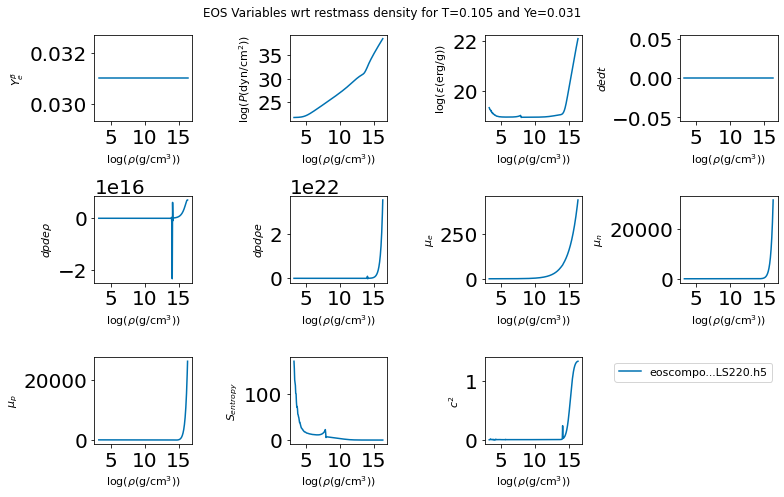

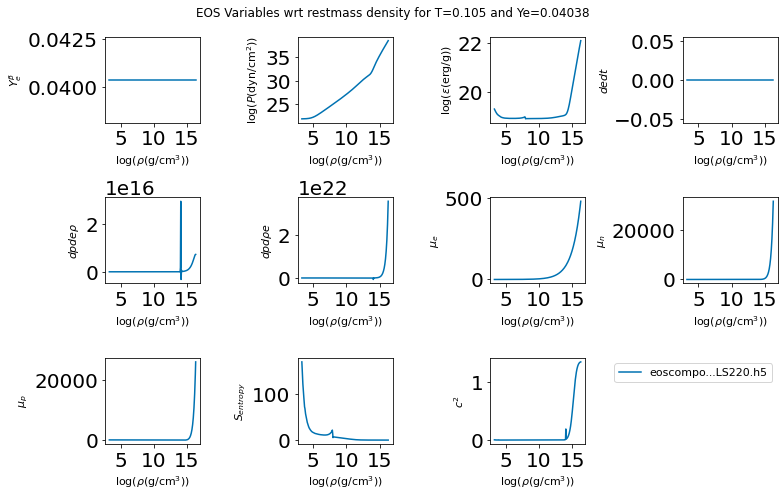

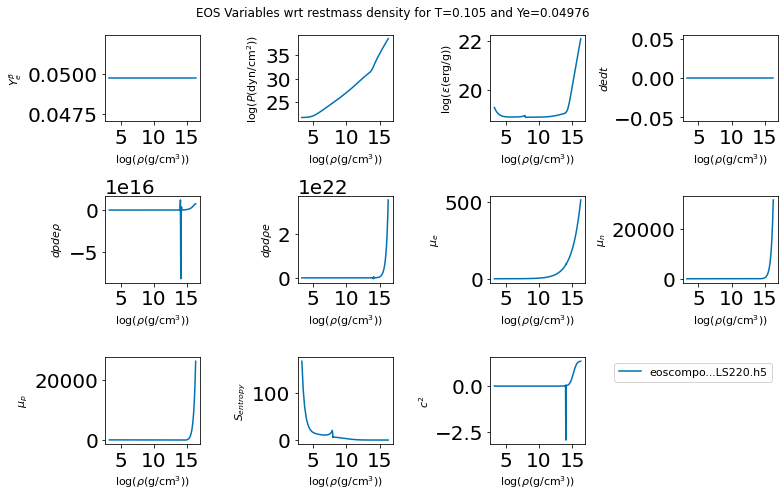

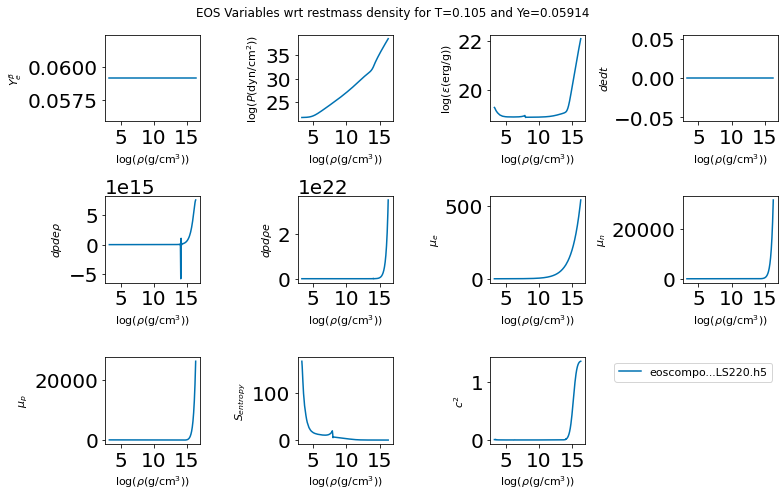

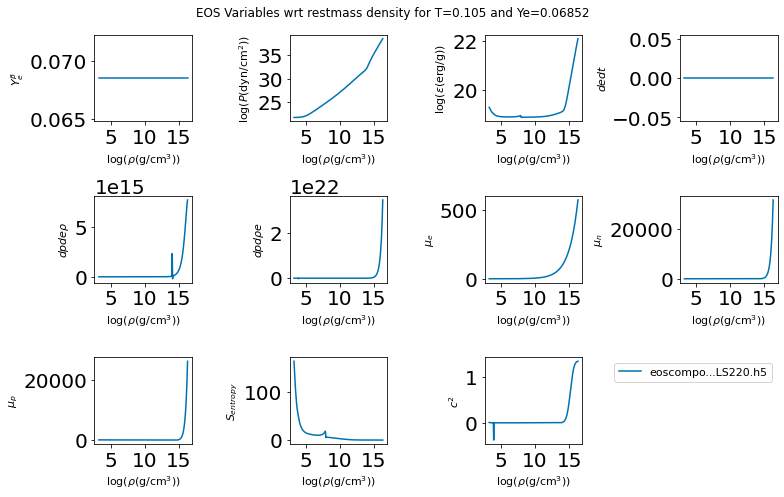

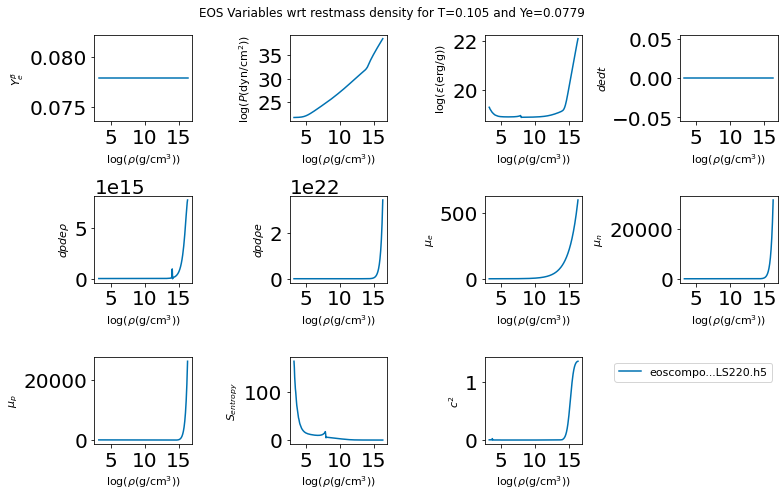

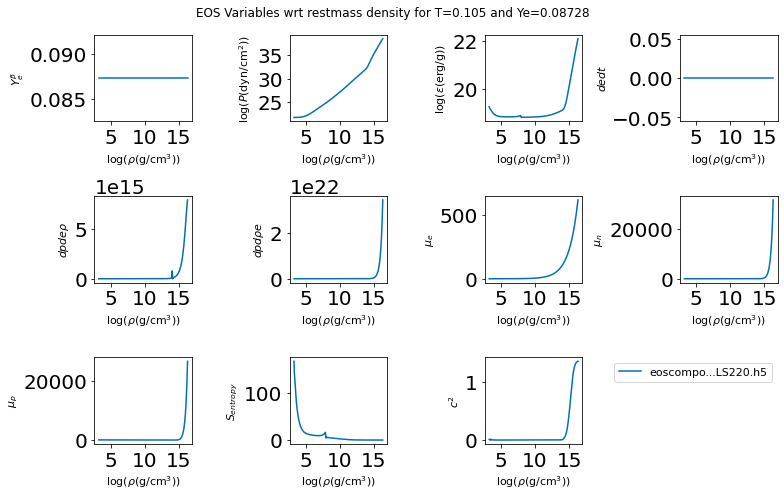

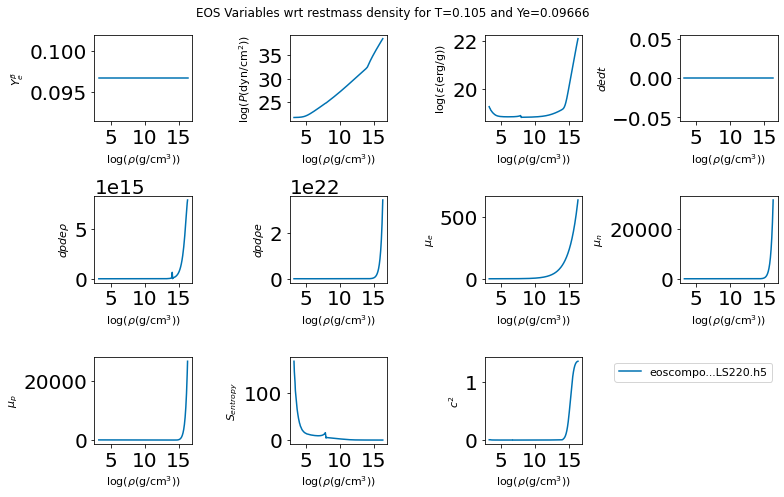

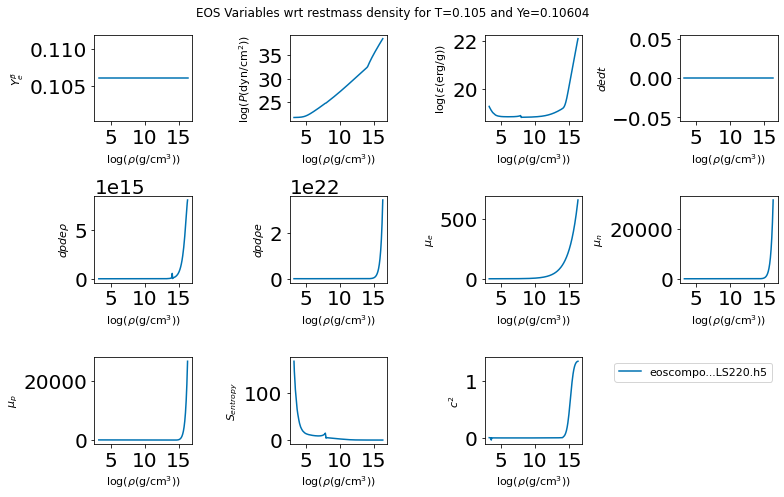

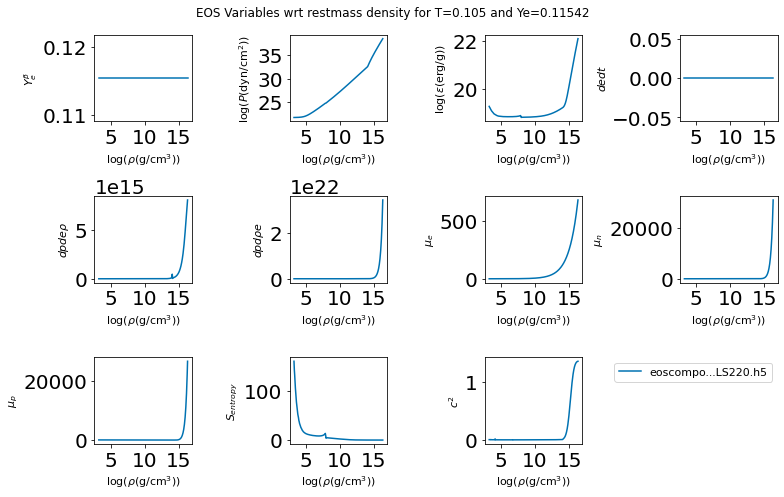

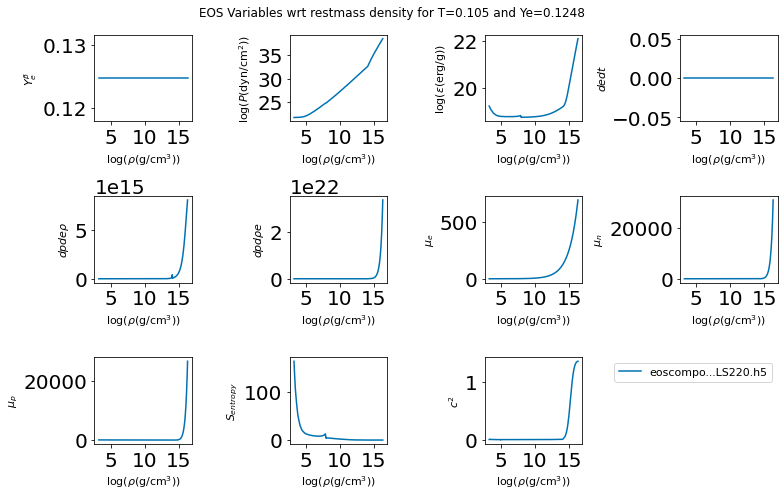

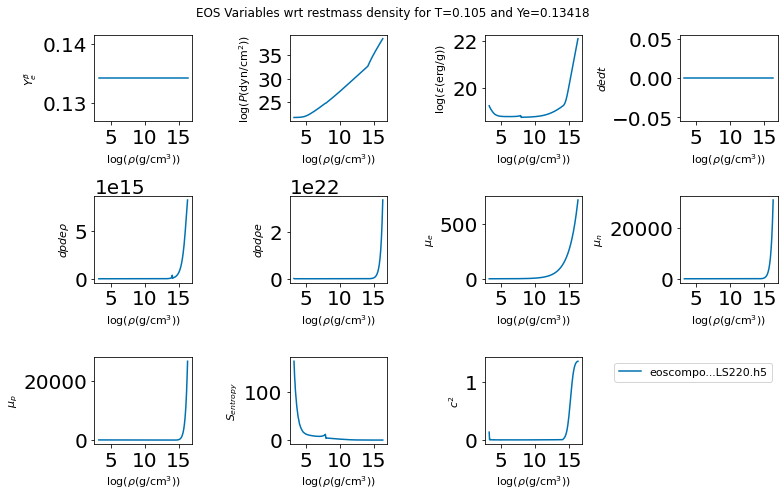

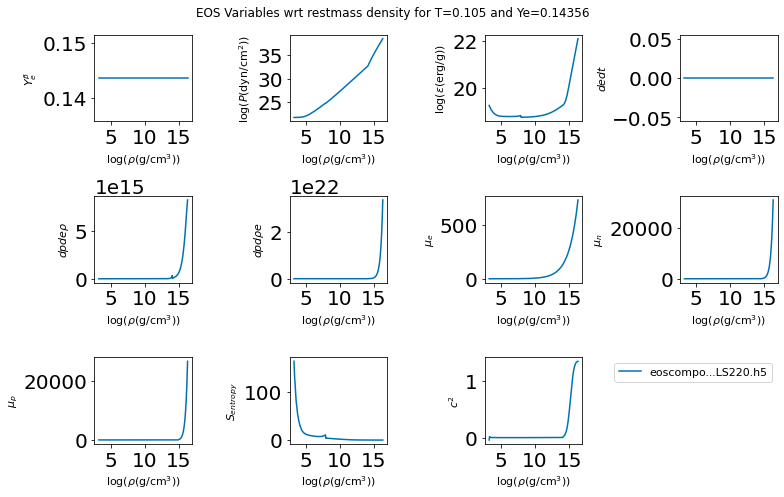

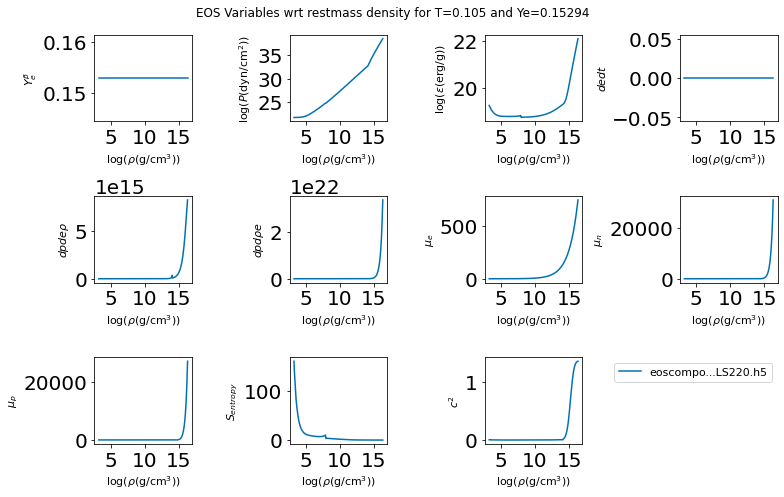

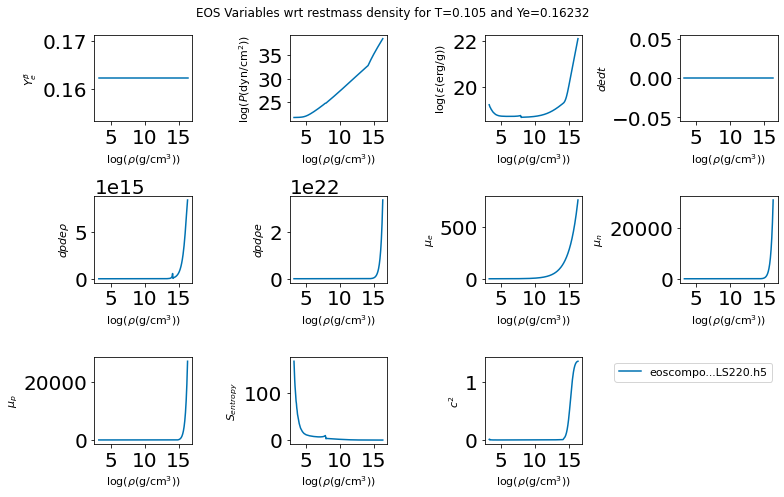

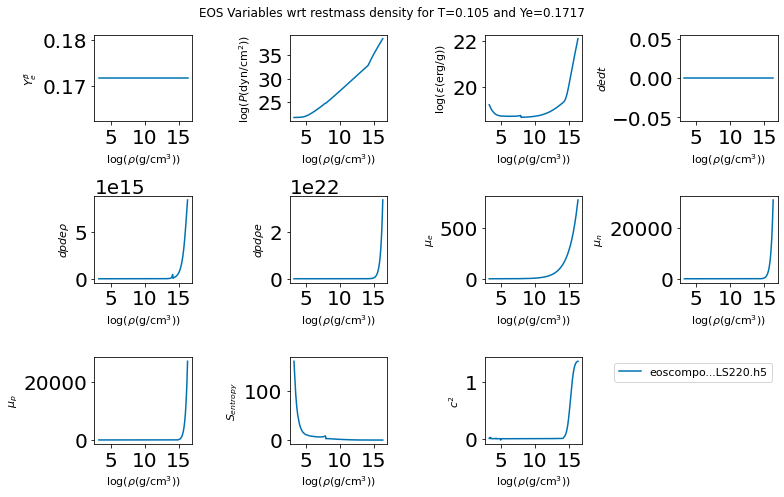

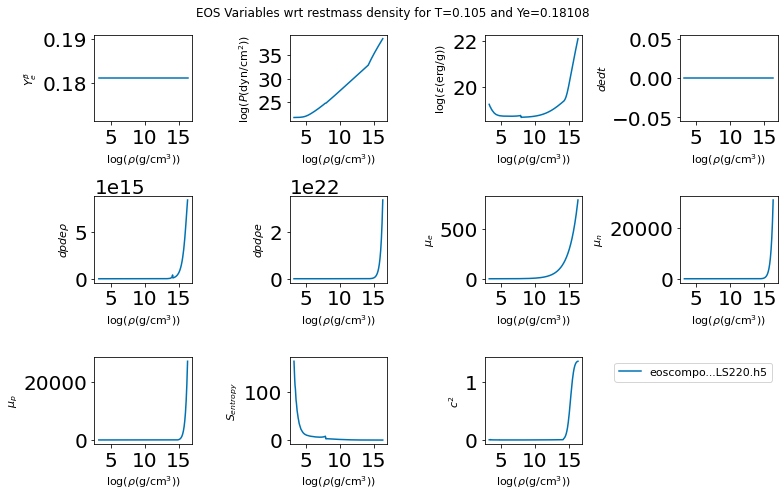

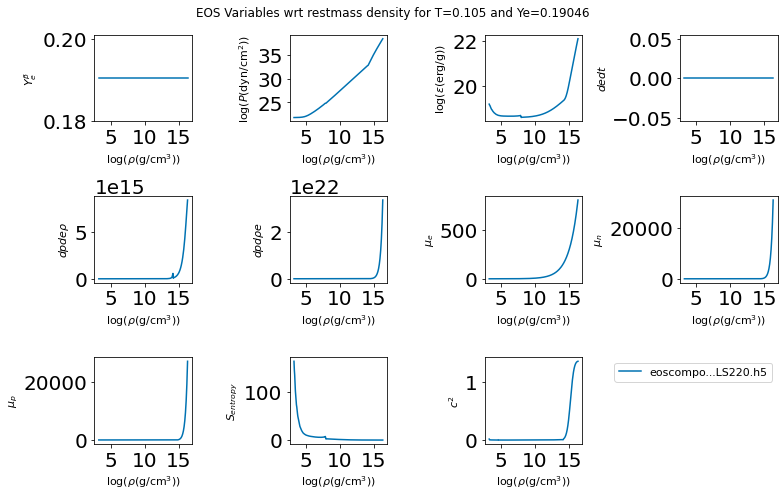

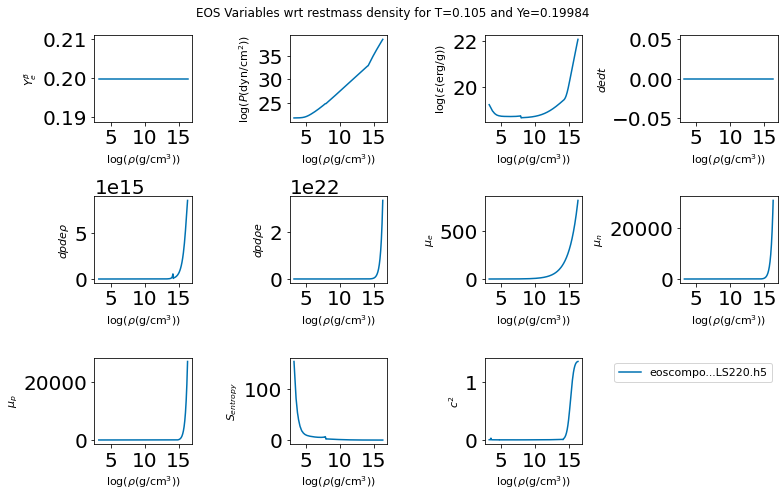

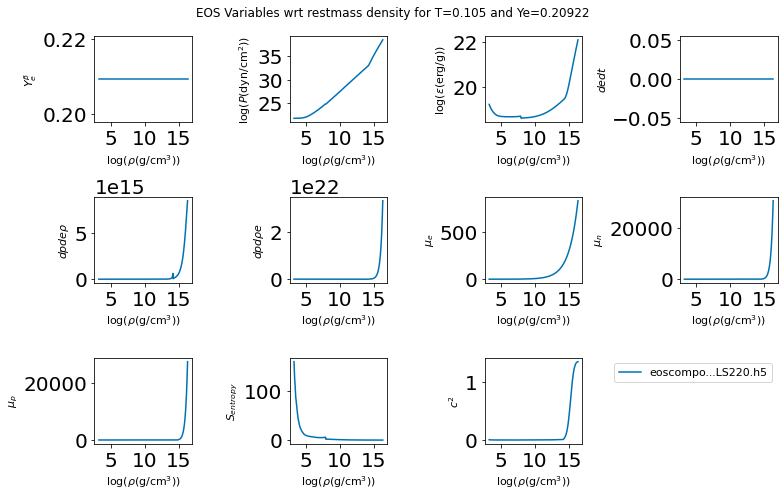

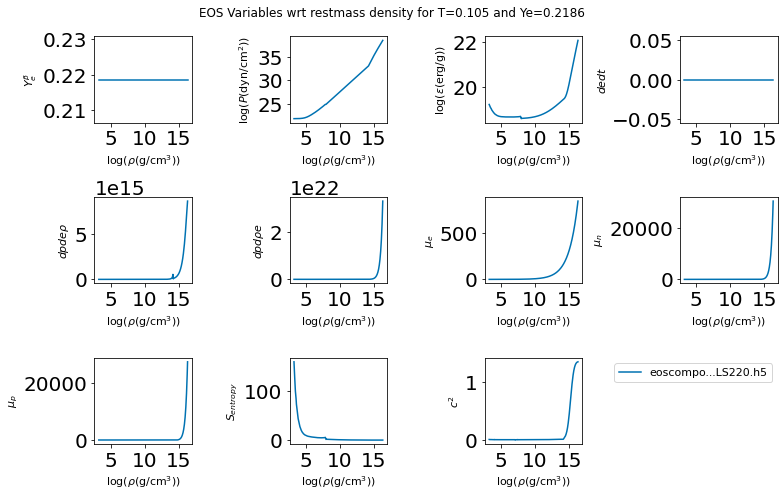

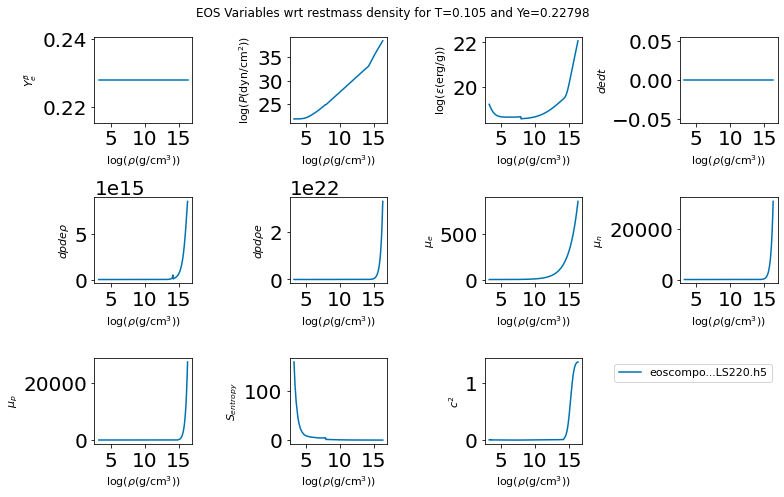

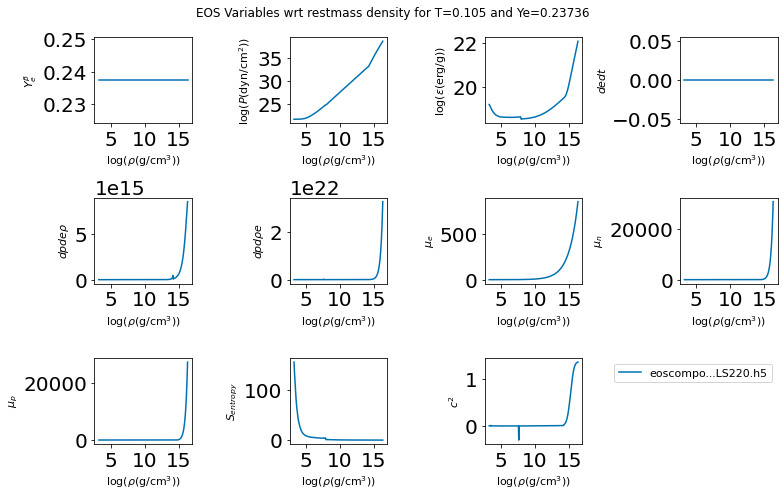

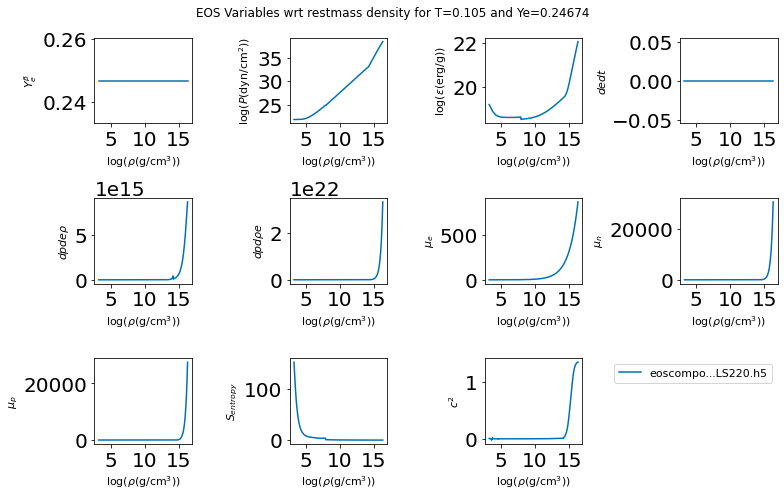

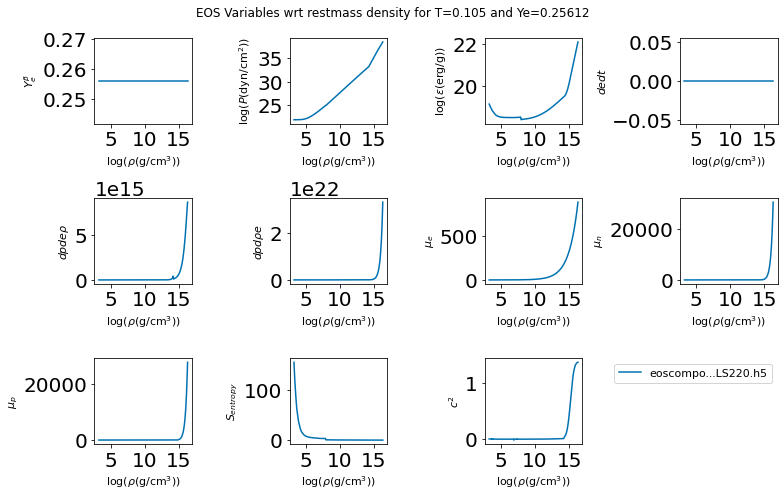

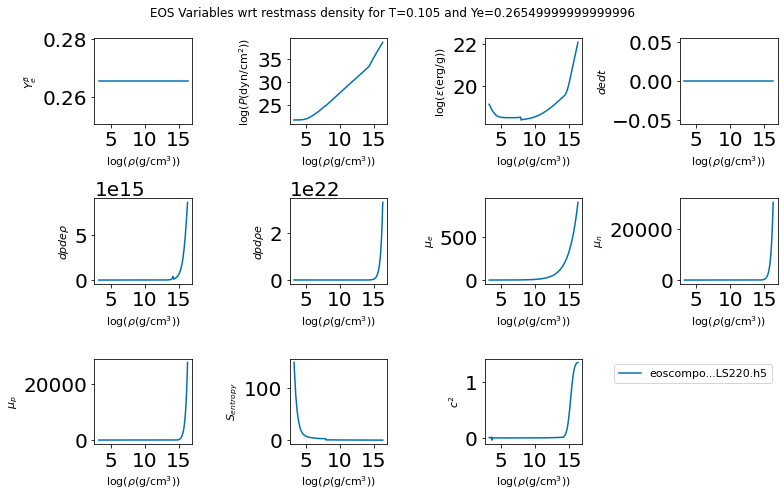

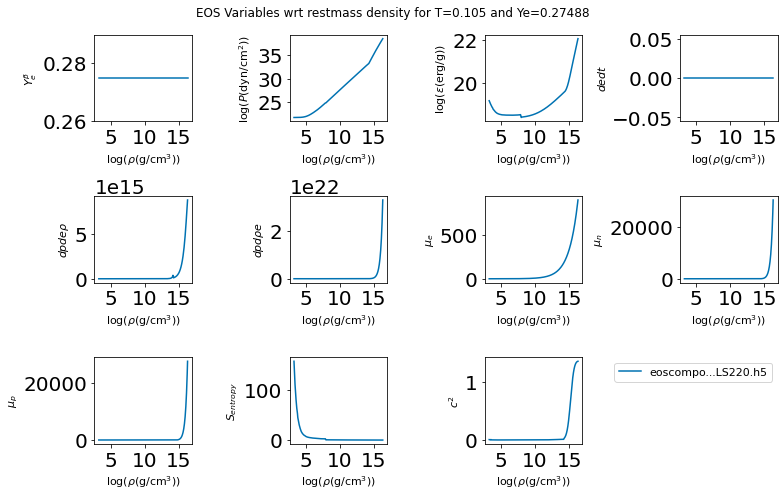

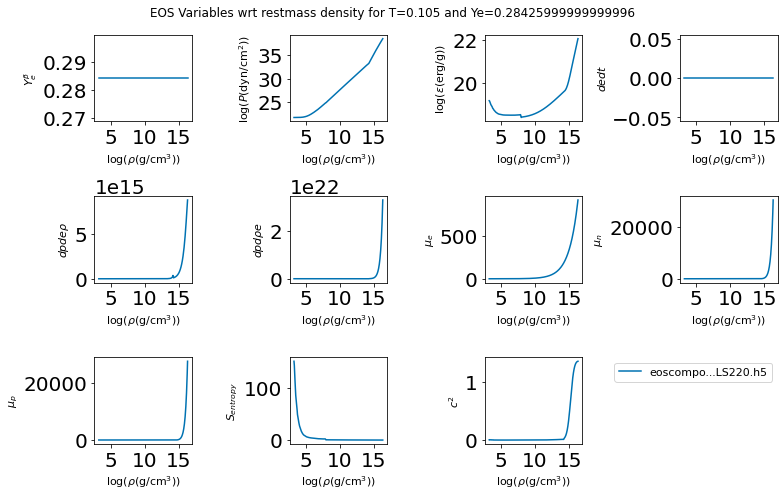

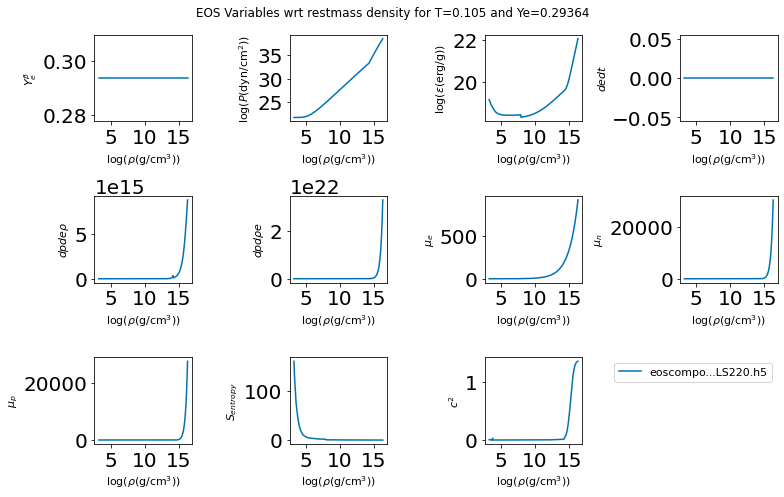

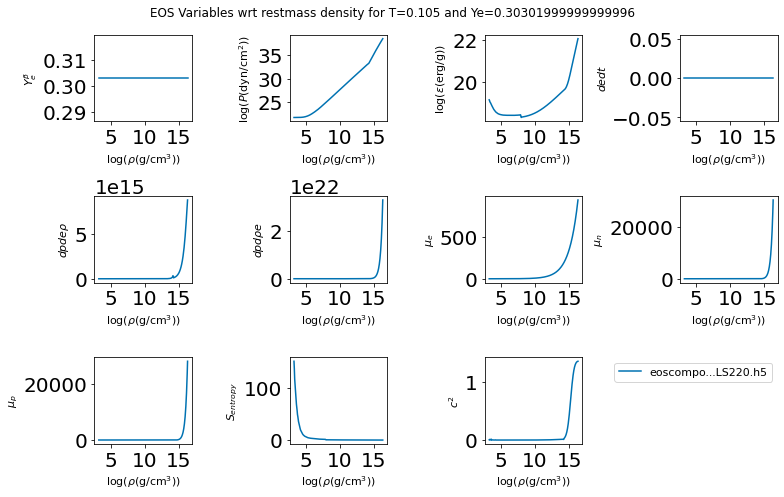

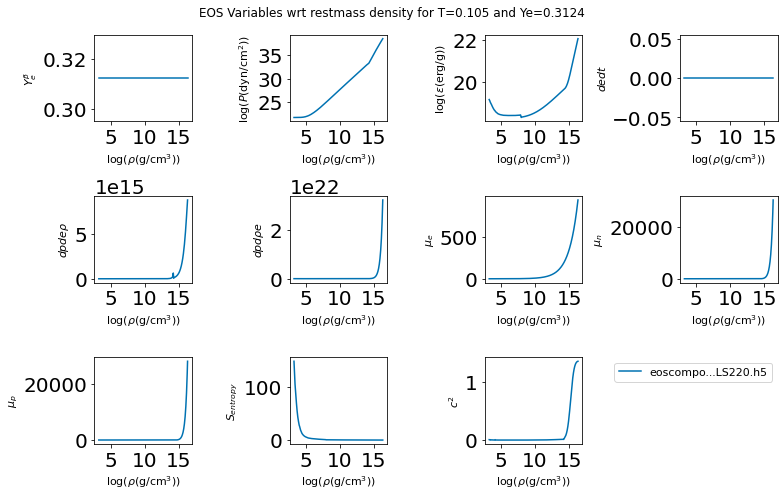

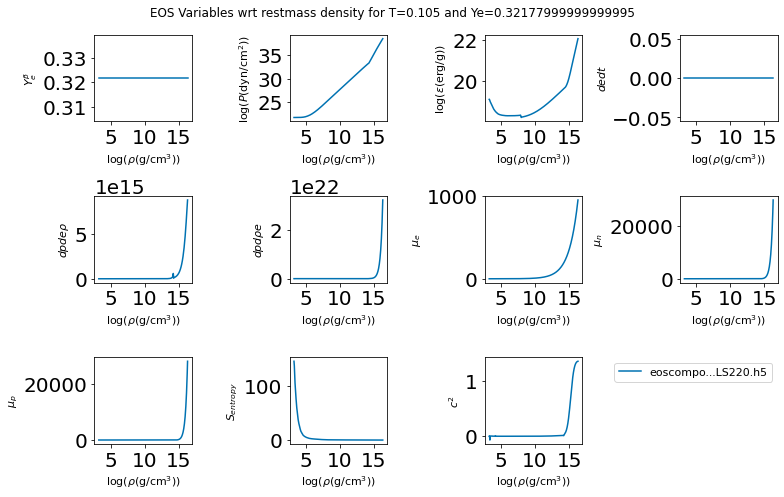

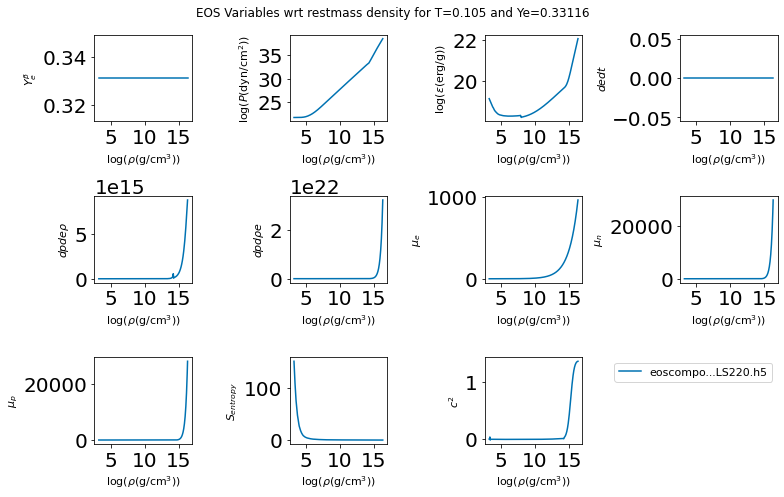

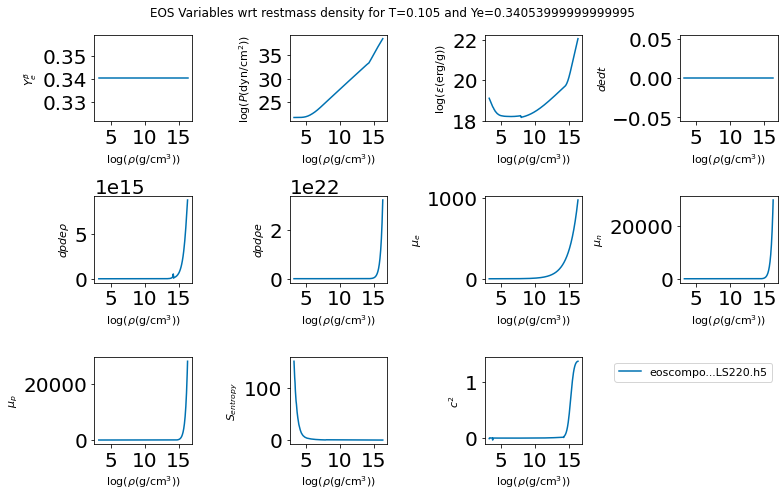

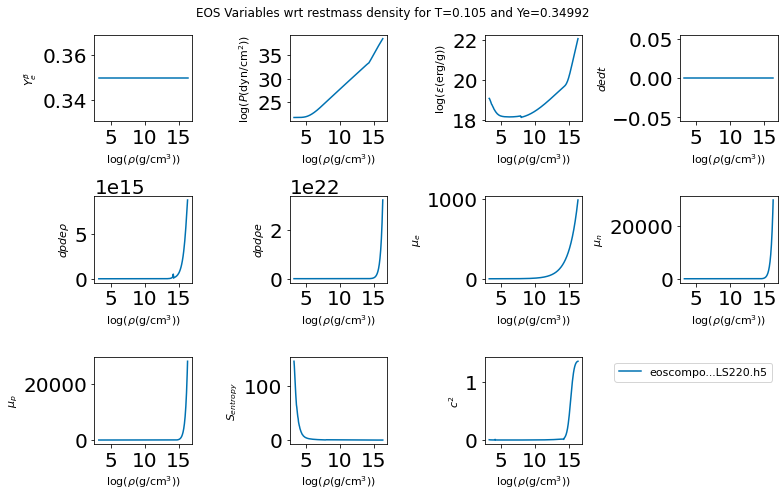

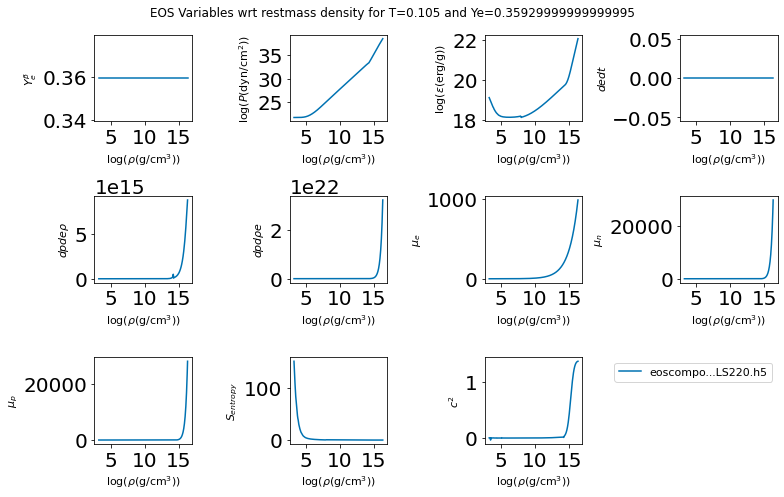

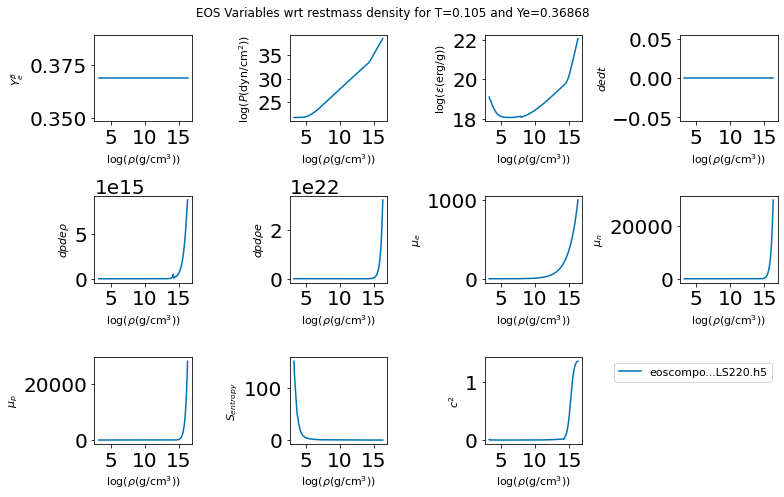

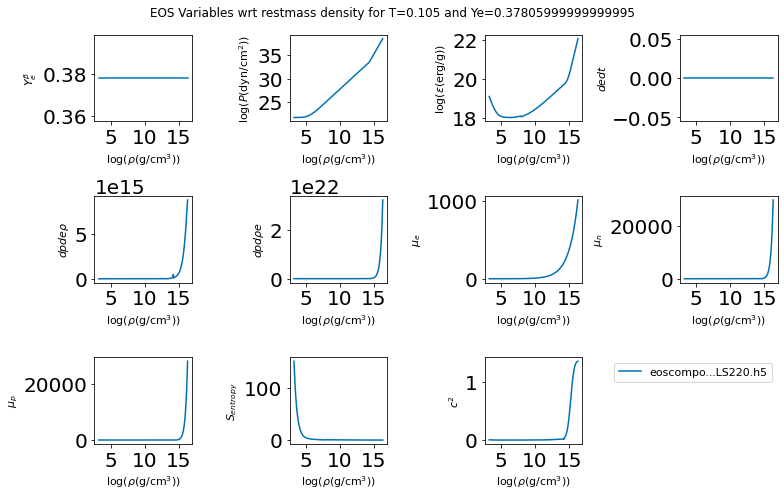

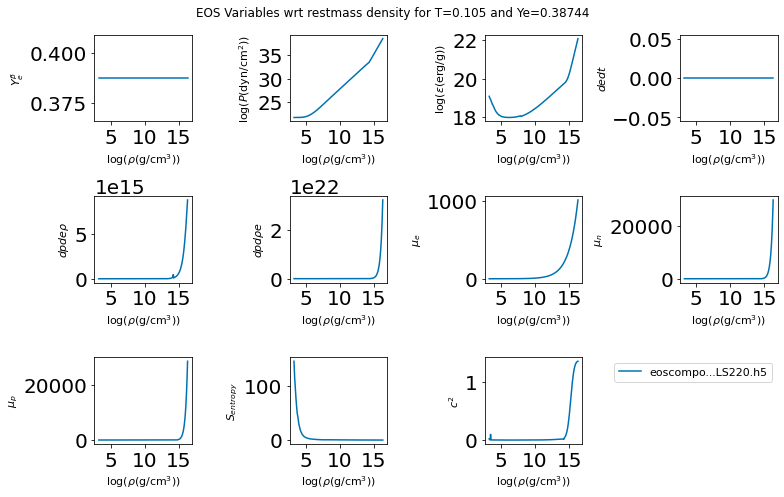

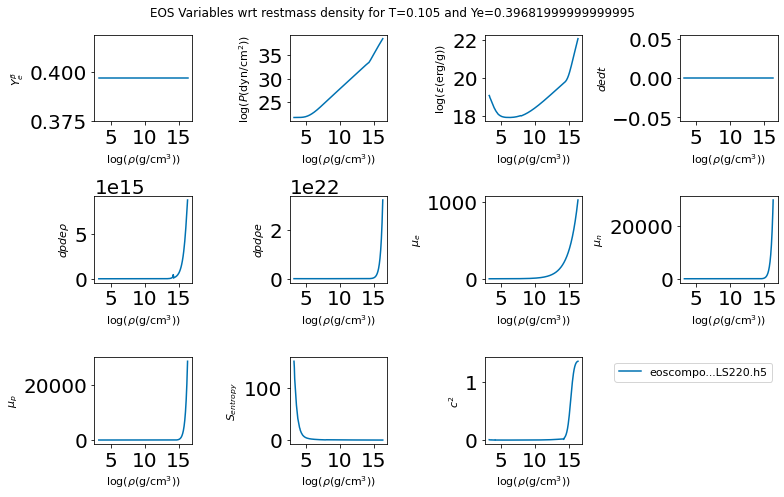

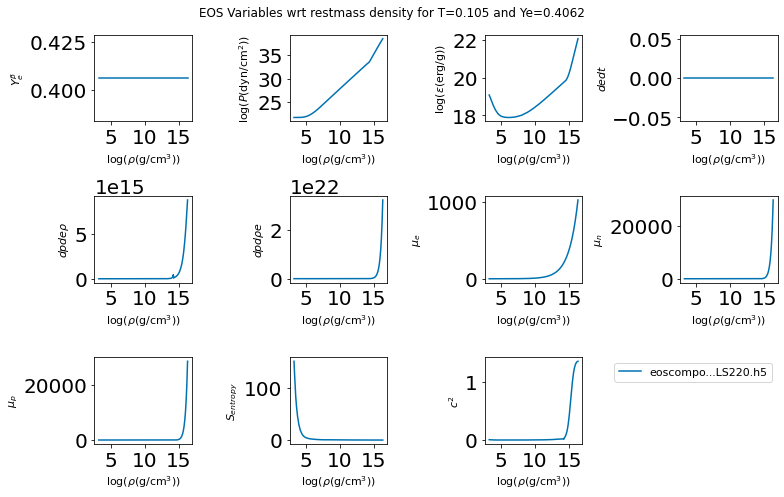

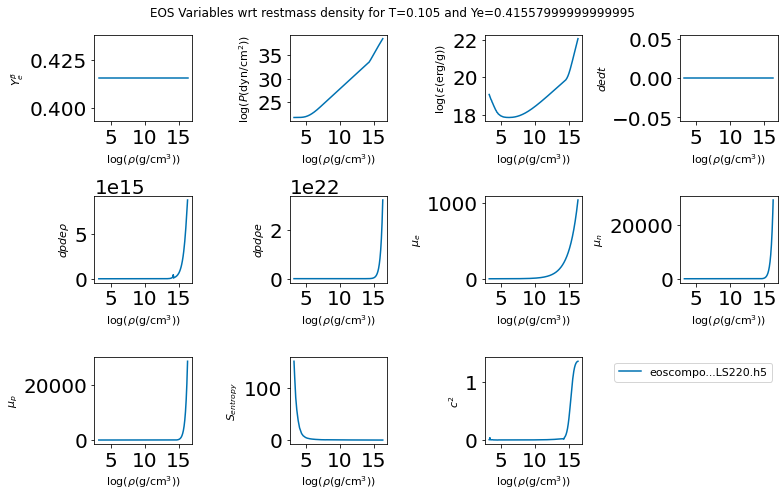

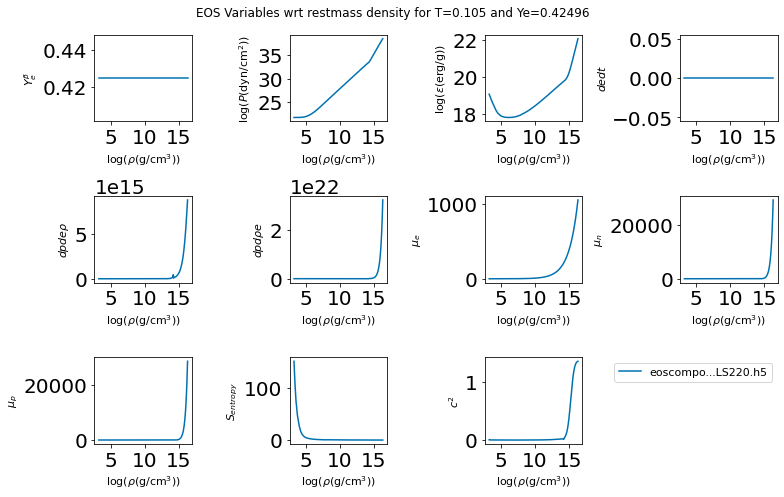

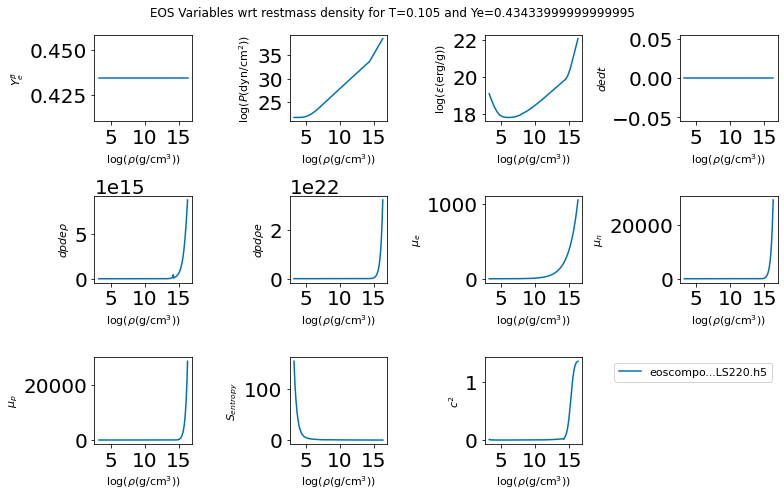

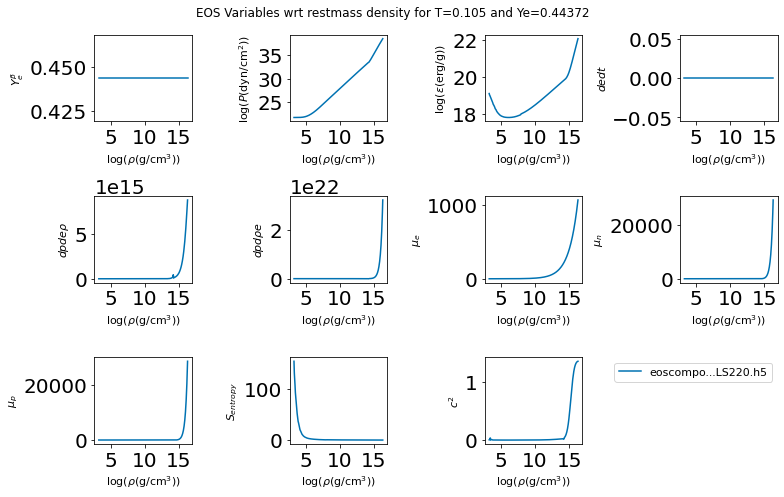

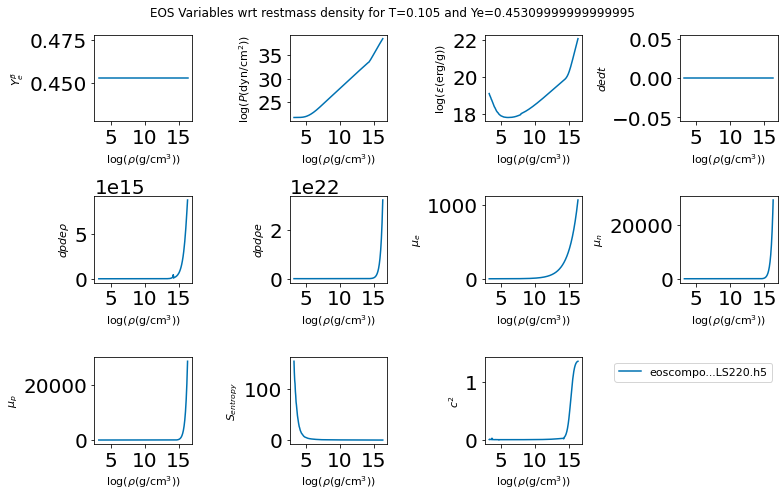

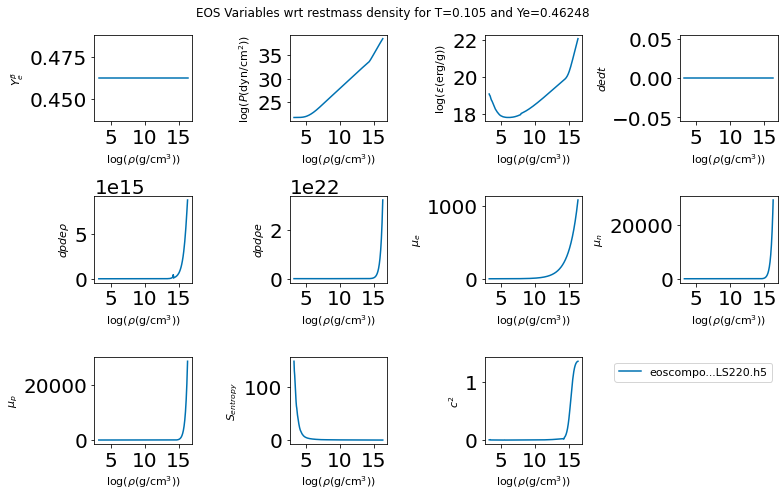

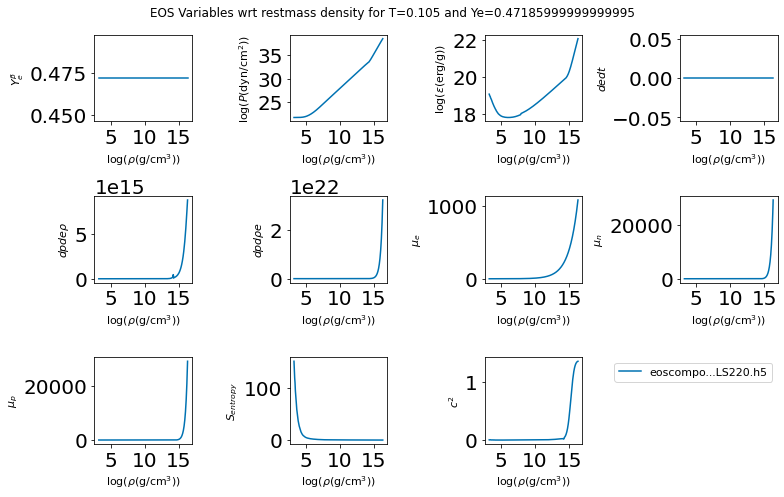

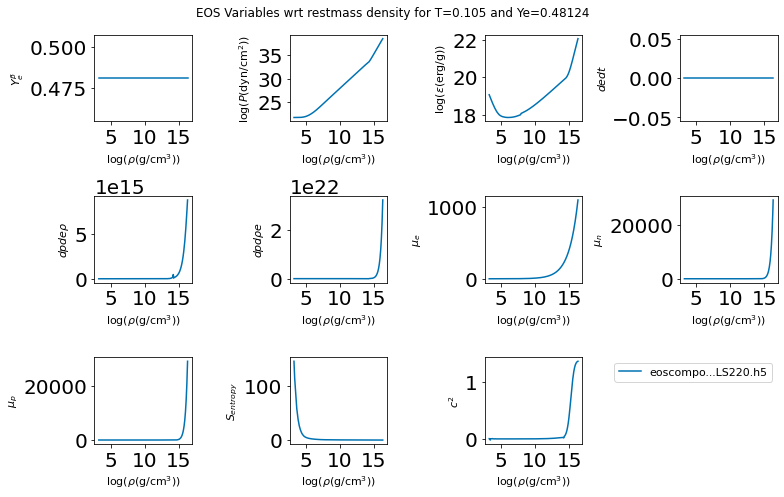

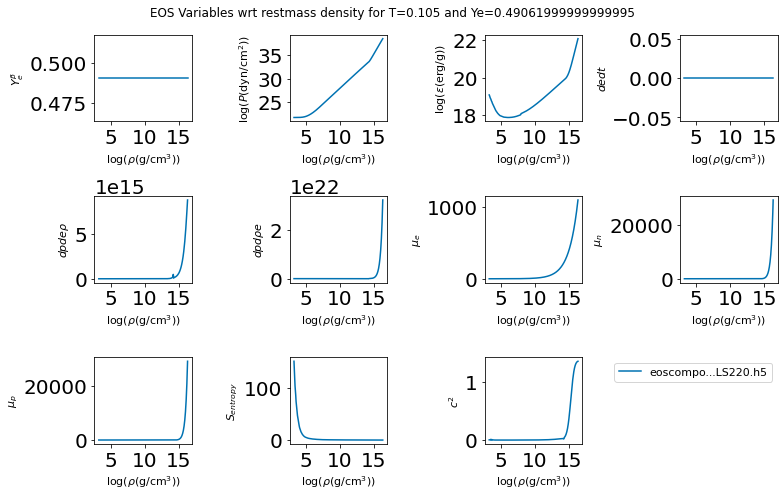

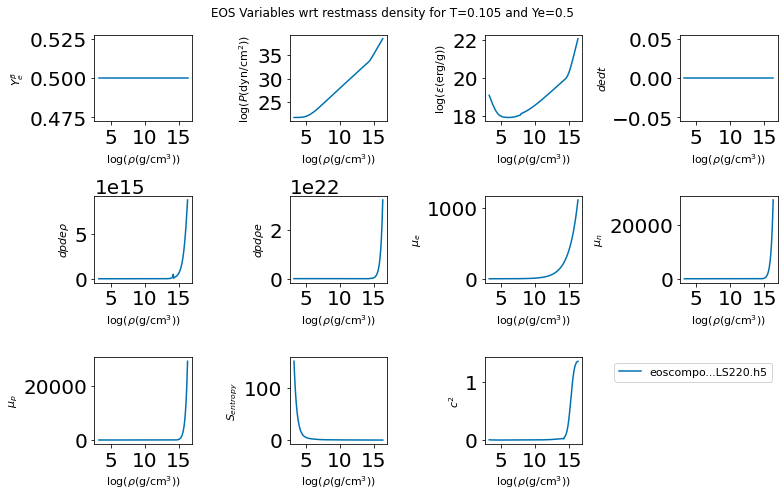

In [56]:
EOS_dict = {}
temp = 0.105
for ye in ye_list:
    fig, logrho, dpderho, dpdrhoe, cs2 = plot_EOS(['eoscompose_converted1_LS220.h5'],ye=ye,T=temp,verbose=False)
    if  min(dpderho)<-0.1 or min(dpdrhoe)<-0.1:
        fig.savefig('intrinsic_ye_T105/'+str(ye)+'.png')
        EOS_dict[str(ye)] = [fig, logrho, dpderho, dpdrhoe, cs2]


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59]
[0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12
 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26
 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4
 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54
 0.55 0.56 0.57 0.58]
[0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12
 0.13 0.14 0

[0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07 0.06 0.05 0.04 0.03 0.02 0.01
 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45]
[0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07 0.06 0.05 0.04 0.03 0.02 0.01
 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45]
[0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07 0.06 0.05 0.04 0.03 0.02
 0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12
 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26
 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4
 0.41 0.42 0.43 0.44]
[0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07 0.06 0.05 0.04 0.03 0.02
 0.01 0.   0

/var/folders/nr/rbr3ndbn343d7__44zxt3v780000gn/T/ipykernel_62913/626921075.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax= plt.subplots(nrows=3, ncols=4,figsize=(11,7), tight_layout=True)


[0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07
 0.06 0.05 0.04 0.03 0.02 0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07
 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21
 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35
 0.36 0.37 0.38 0.39]
[0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07
 0.06 0.05 0.04 0.03 0.02 0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07
 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21
 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35
 0.36 0.37 0.38 0.39]
[0.21 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08
 0.07 0.06 0.05 0.04 0.03 0.02 0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06
 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2
 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34
 0.35 0.36 0.37 0.38]
[0.21 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08
 0.07 0.06 0

[0.34 0.33 0.32 0.31 0.3  0.29 0.28 0.27 0.26 0.25 0.24 0.23 0.22 0.21
 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07
 0.06 0.05 0.04 0.03 0.02 0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07
 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21
 0.22 0.23 0.24 0.25]
[0.34 0.33 0.32 0.31 0.3  0.29 0.28 0.27 0.26 0.25 0.24 0.23 0.22 0.21
 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07
 0.06 0.05 0.04 0.03 0.02 0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07
 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21
 0.22 0.23 0.24 0.25]
[0.35 0.34 0.33 0.32 0.31 0.3  0.29 0.28 0.27 0.26 0.25 0.24 0.23 0.22
 0.21 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08
 0.07 0.06 0.05 0.04 0.03 0.02 0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06
 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2
 0.21 0.22 0.23 0.24]
[0.35 0.34 0.33 0.32 0.31 0.3  0.29 0.28 0.27 0.26 0.25 0.24 0.23 0.22
 0.21 0.2  0

[0.48 0.47 0.46 0.45 0.44 0.43 0.42 0.41 0.4  0.39 0.38 0.37 0.36 0.35
 0.34 0.33 0.32 0.31 0.3  0.29 0.28 0.27 0.26 0.25 0.24 0.23 0.22 0.21
 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07
 0.06 0.05 0.04 0.03 0.02 0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07
 0.08 0.09 0.1  0.11]
[0.48 0.47 0.46 0.45 0.44 0.43 0.42 0.41 0.4  0.39 0.38 0.37 0.36 0.35
 0.34 0.33 0.32 0.31 0.3  0.29 0.28 0.27 0.26 0.25 0.24 0.23 0.22 0.21
 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07
 0.06 0.05 0.04 0.03 0.02 0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07
 0.08 0.09 0.1  0.11]
[0.49 0.48 0.47 0.46 0.45 0.44 0.43 0.42 0.41 0.4  0.39 0.38 0.37 0.36
 0.35 0.34 0.33 0.32 0.31 0.3  0.29 0.28 0.27 0.26 0.25 0.24 0.23 0.22
 0.21 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08
 0.07 0.06 0.05 0.04 0.03 0.02 0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06
 0.07 0.08 0.09 0.1 ]
[0.49 0.48 0.47 0.46 0.45 0.44 0.43 0.42 0.41 0.4  0.39 0.38 0.37 0.36
 0.35 0.34 

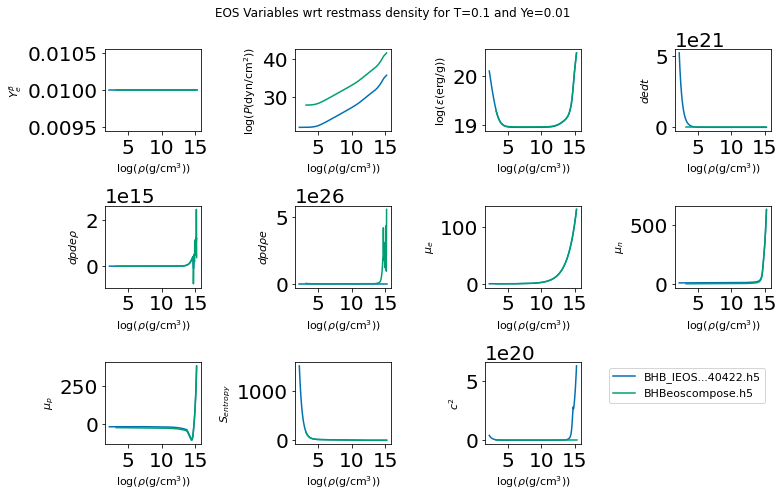

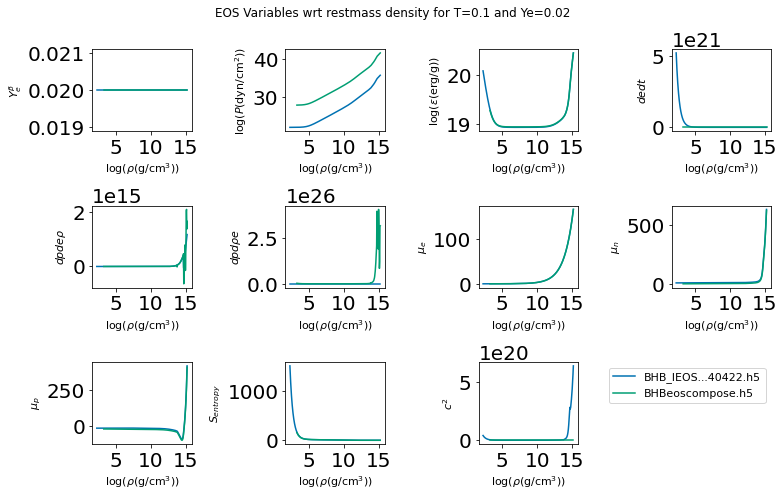

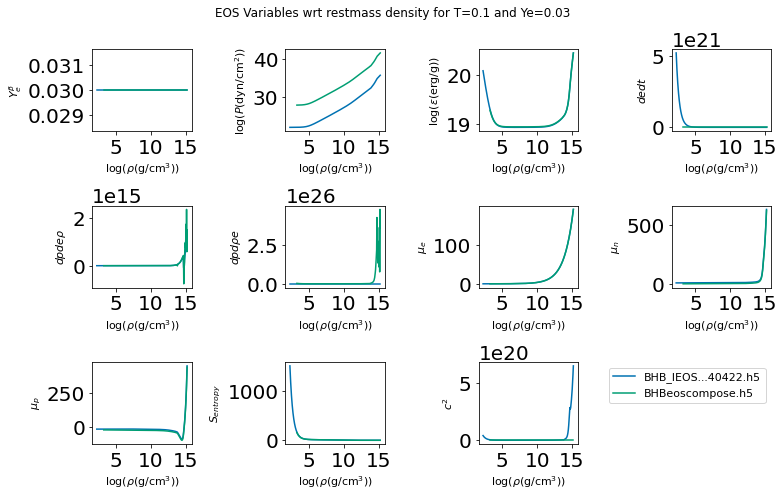

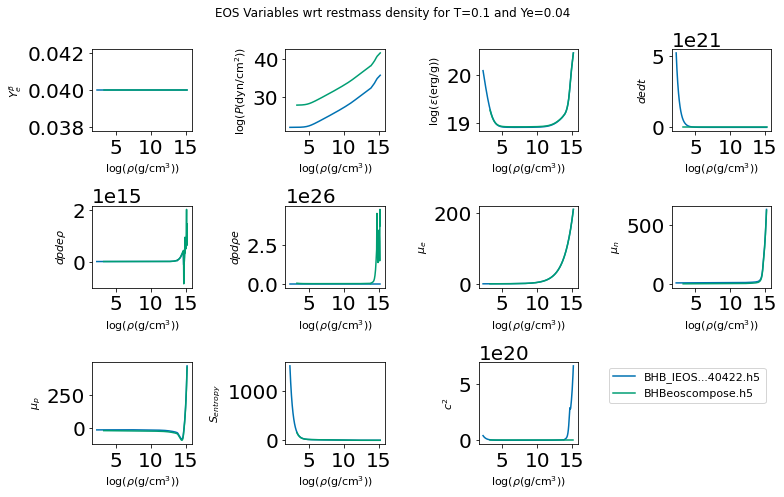

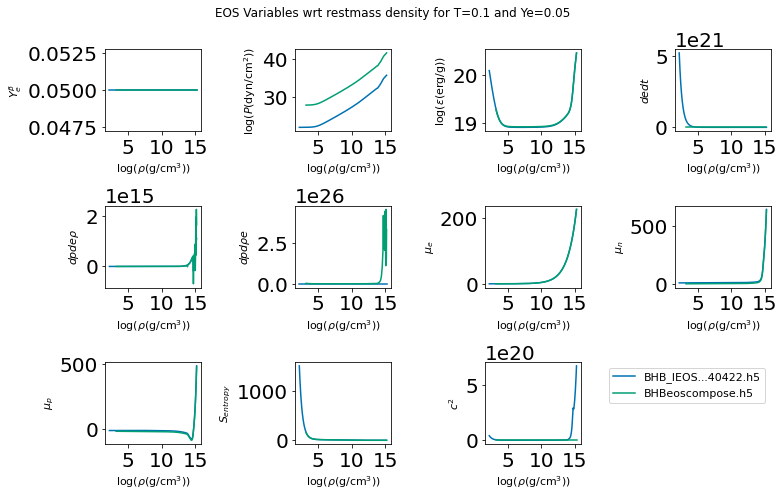

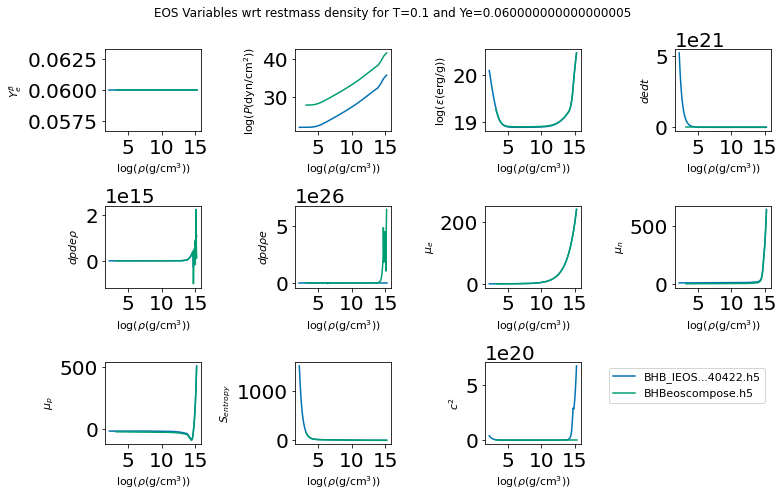

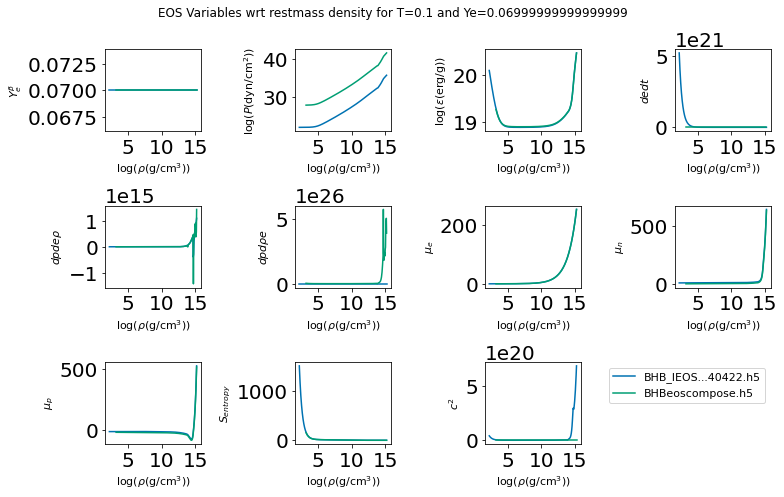

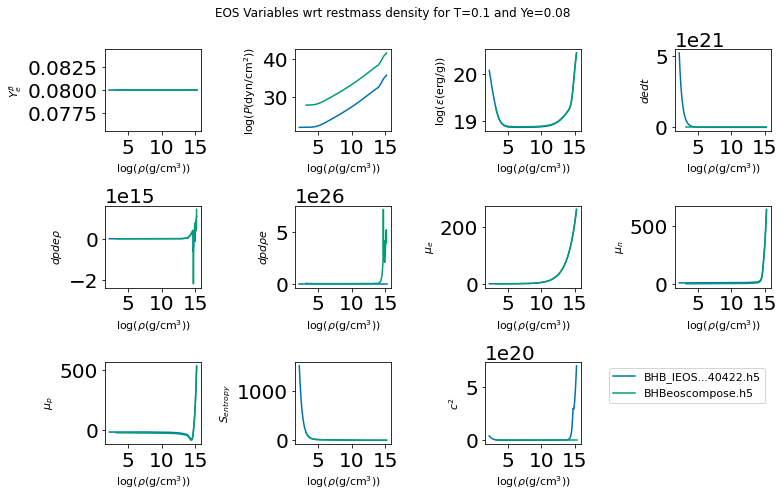

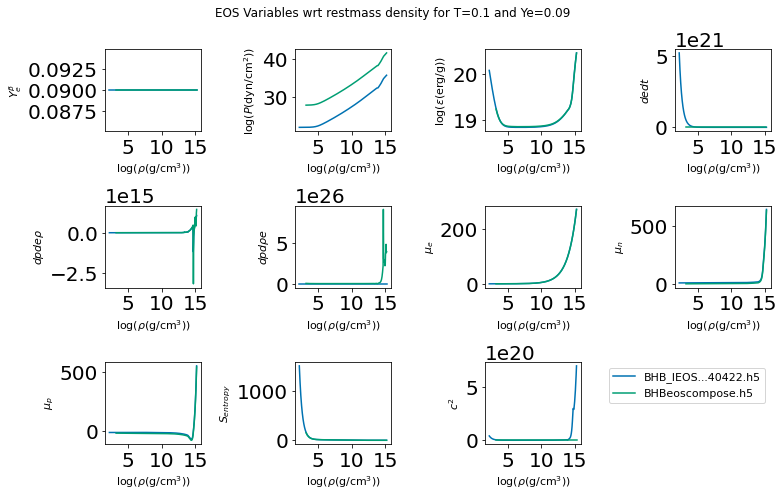

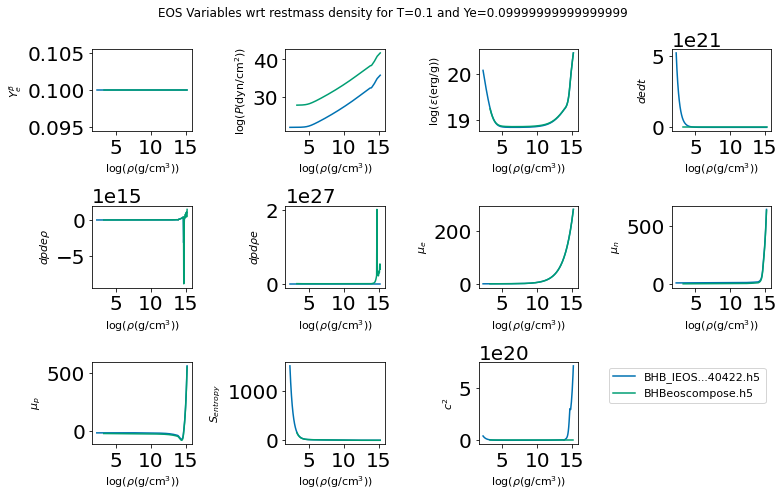

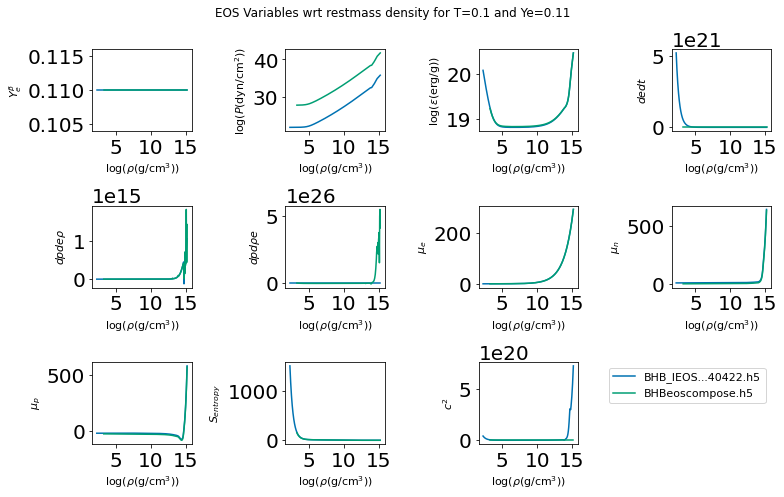

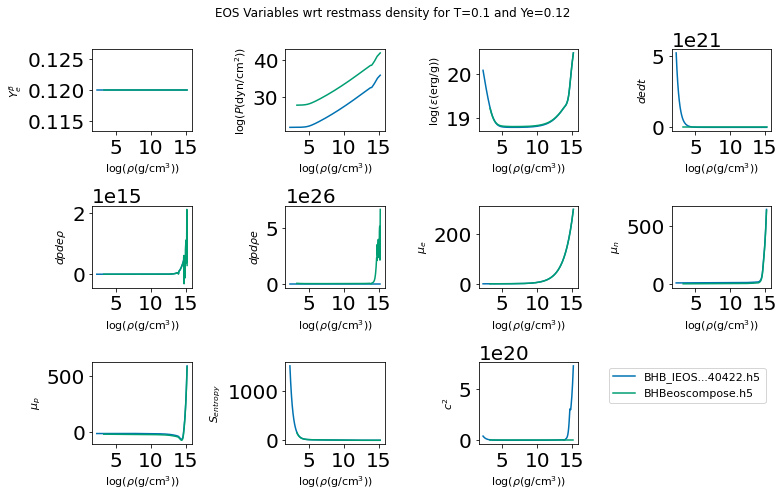

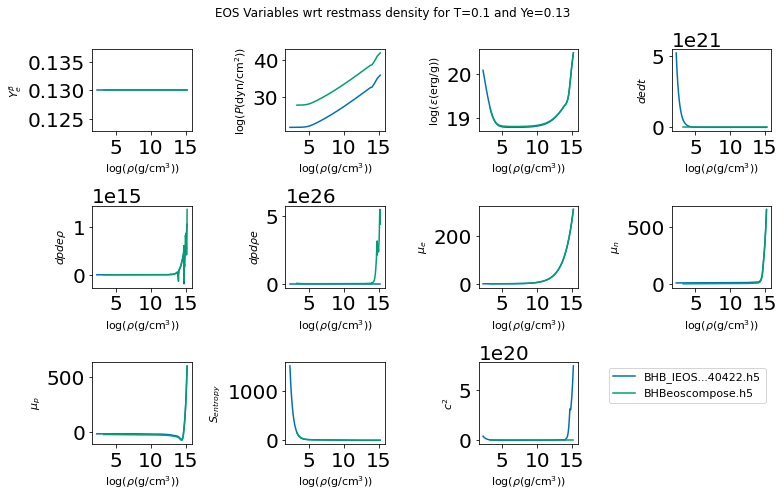

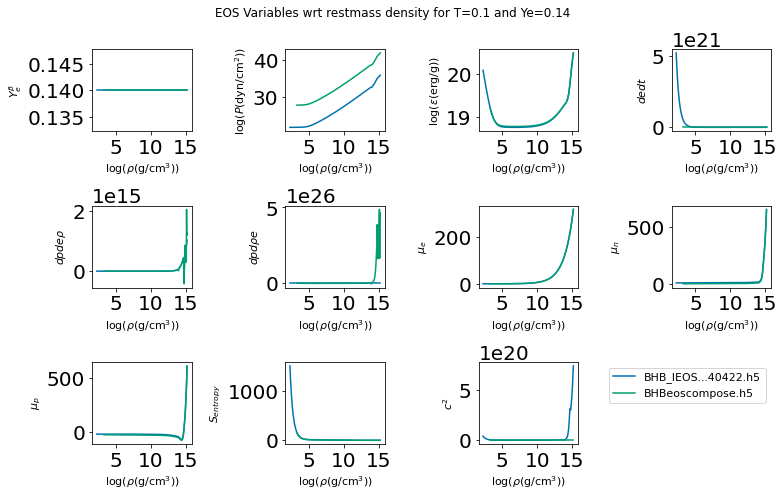

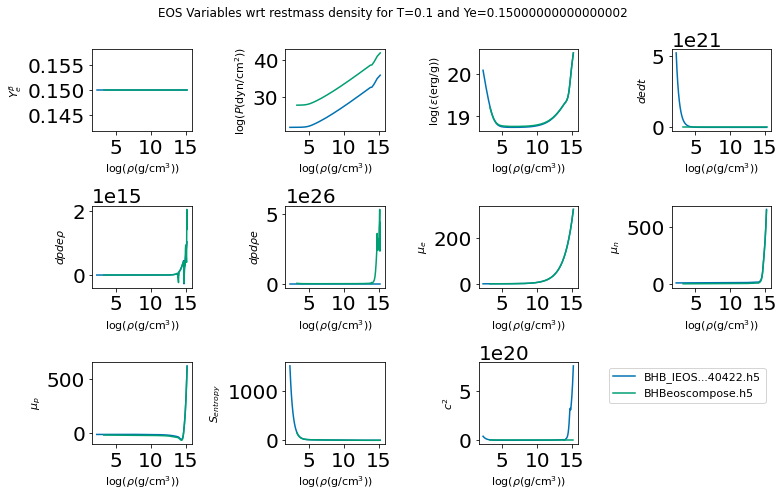

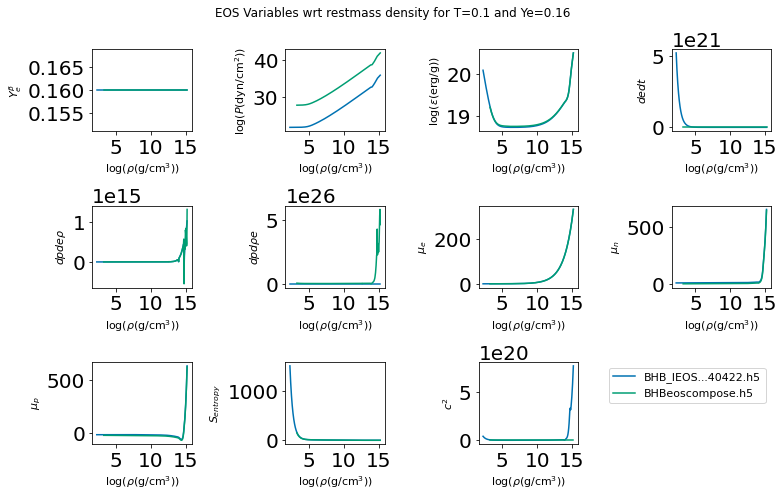

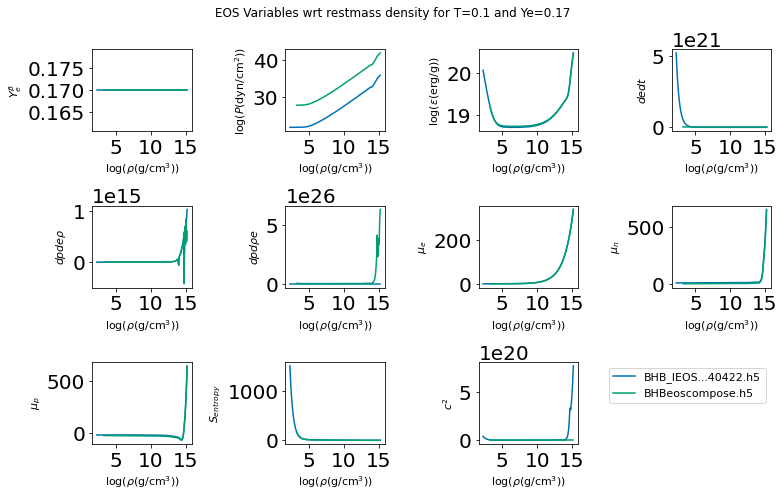

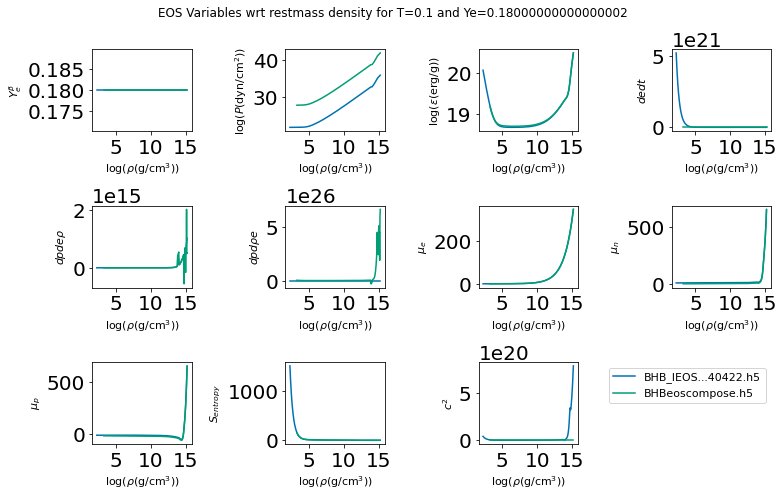

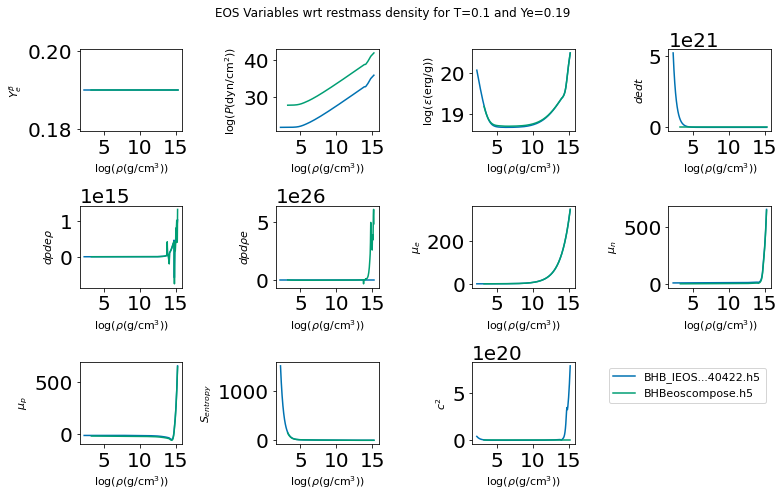

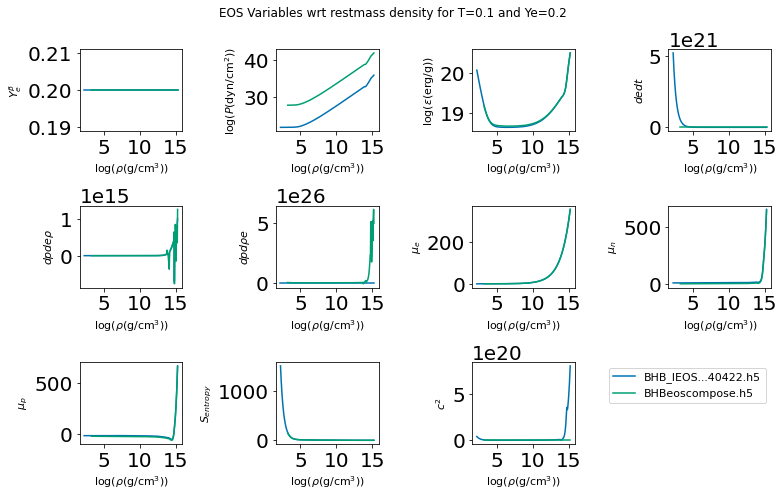

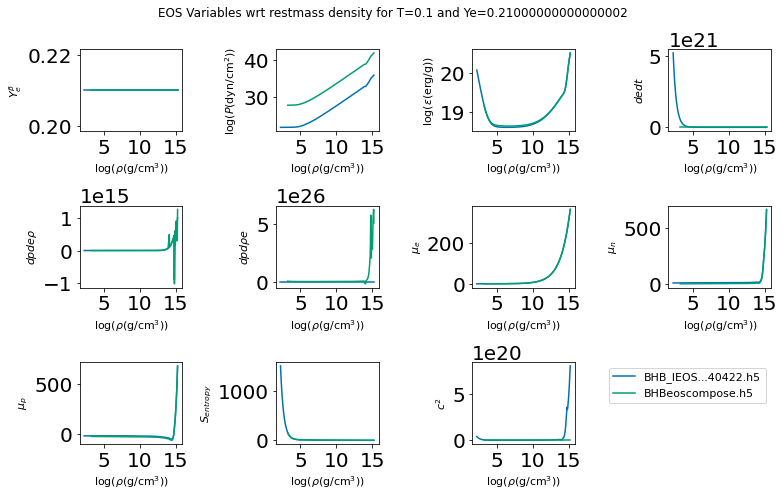

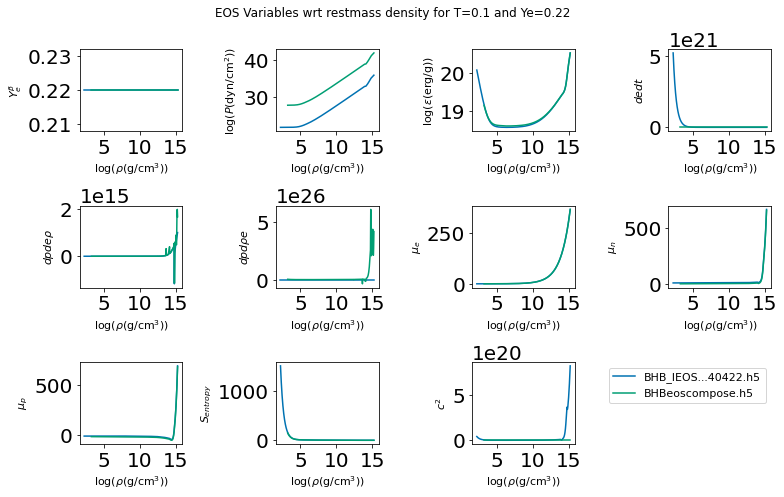

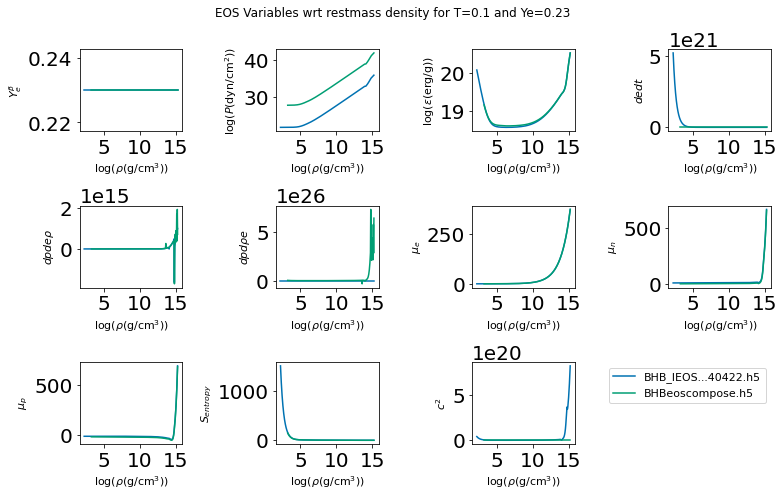

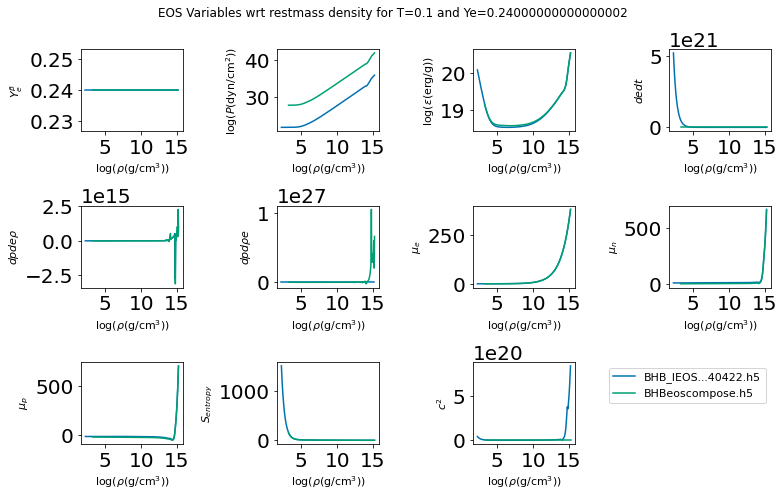

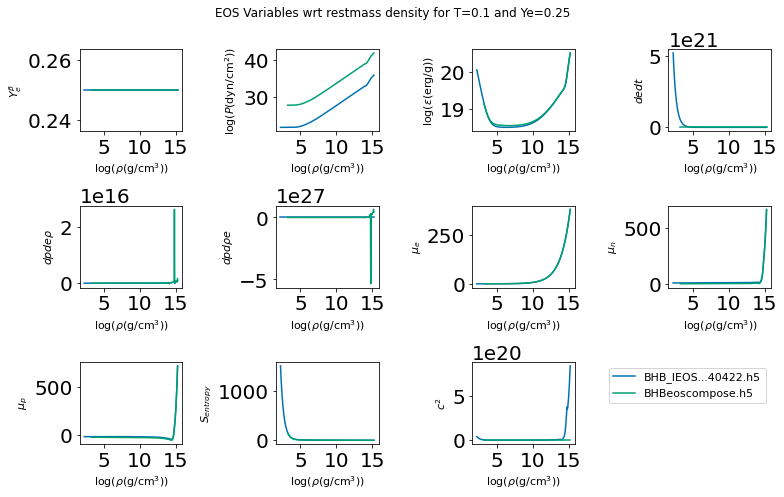

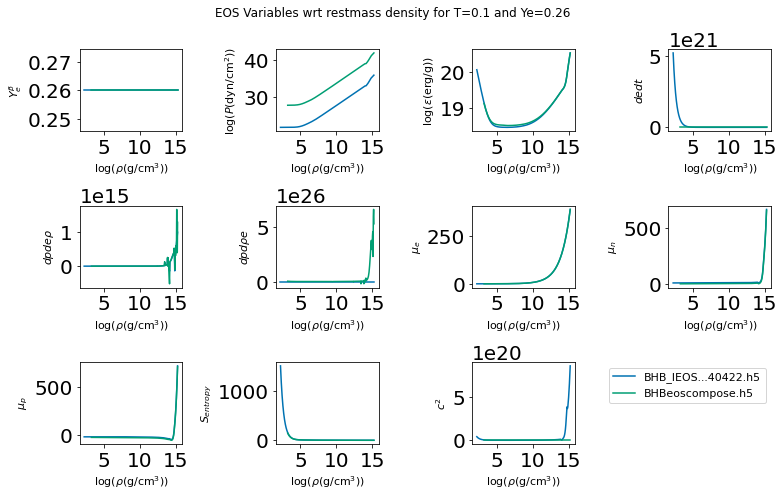

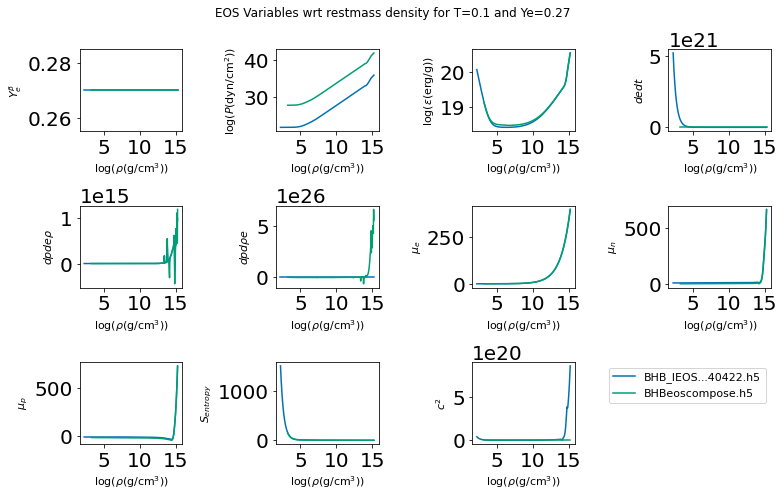

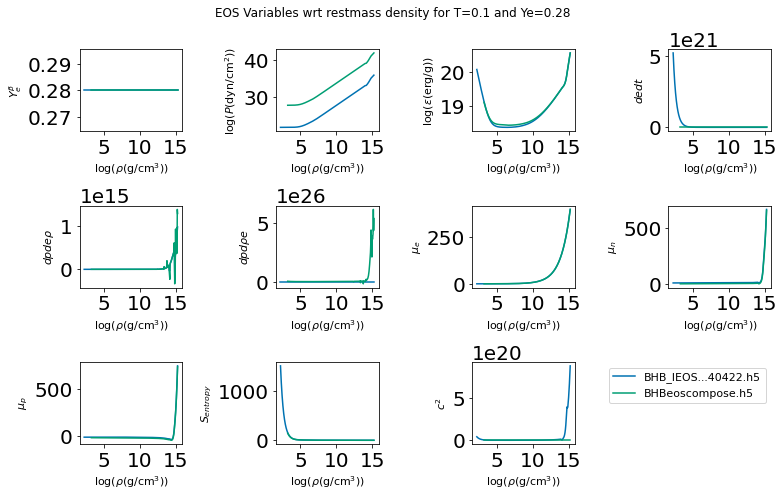

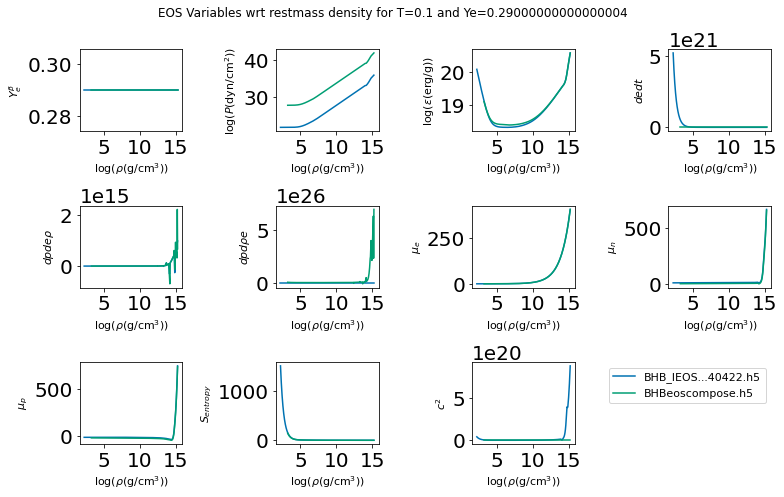

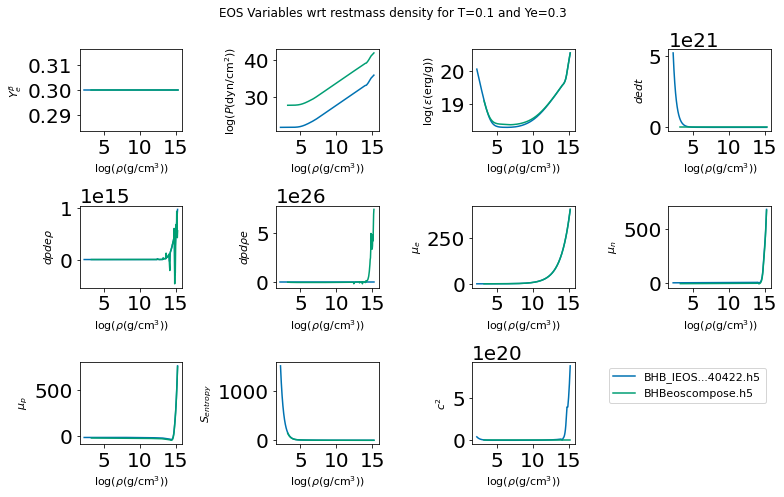

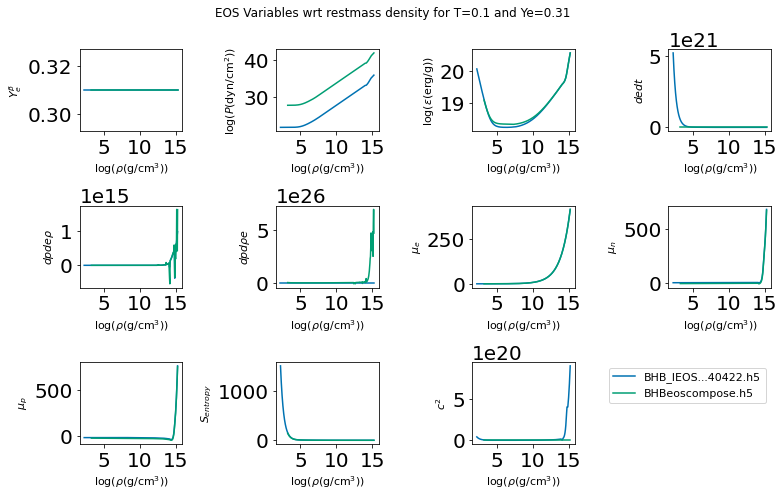

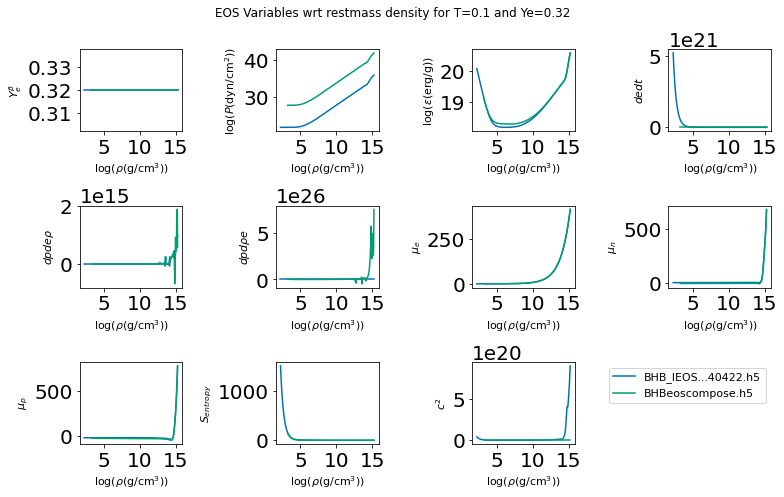

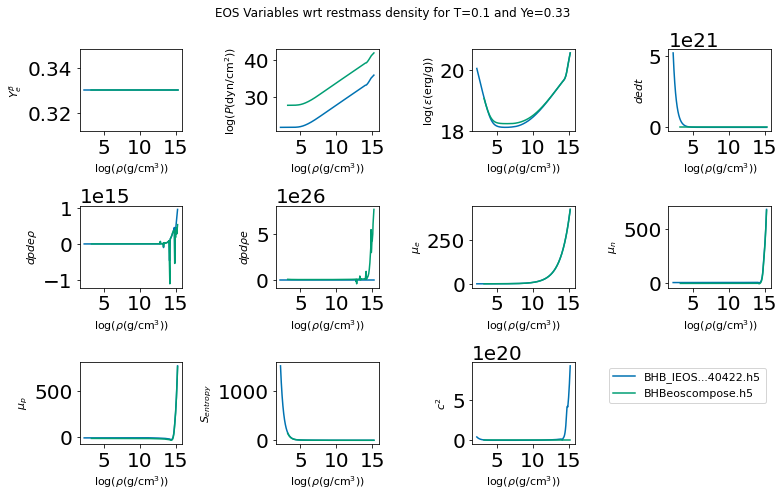

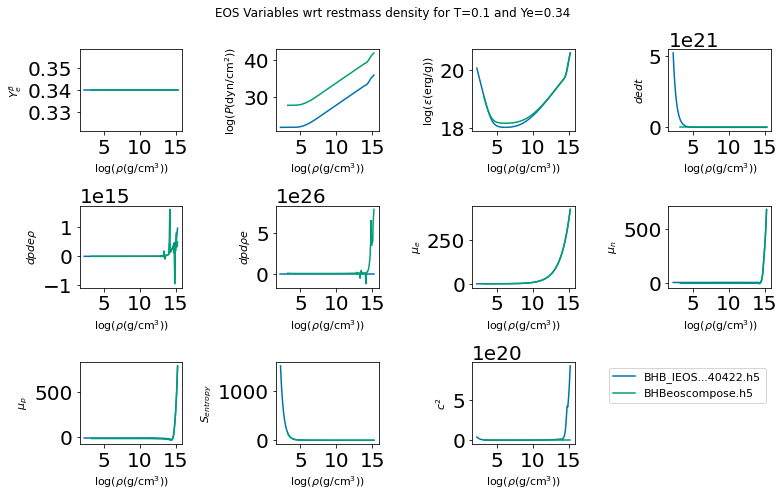

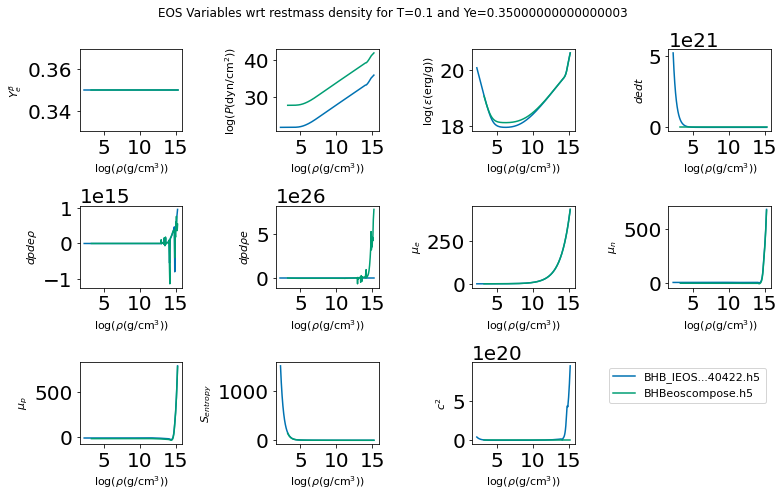

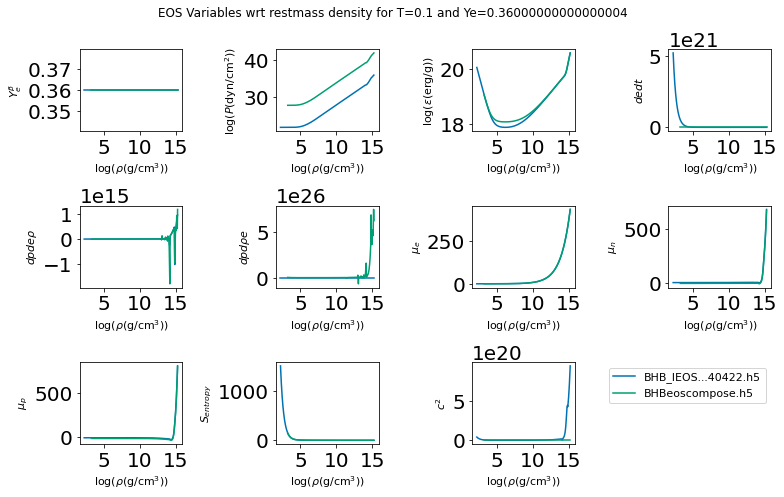

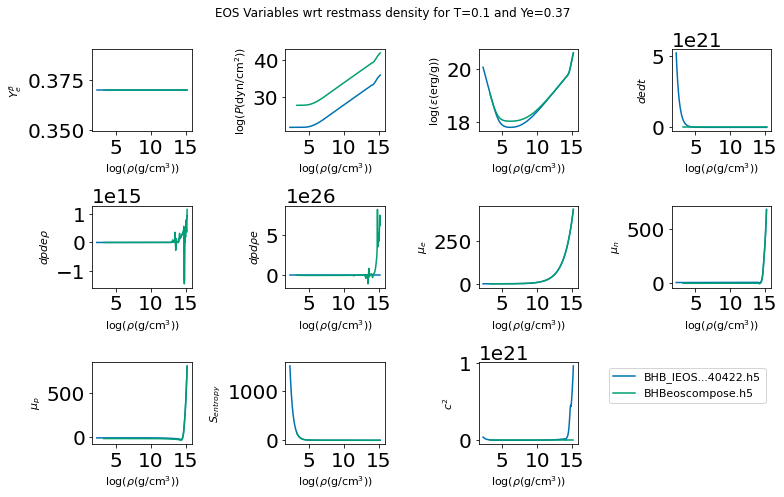

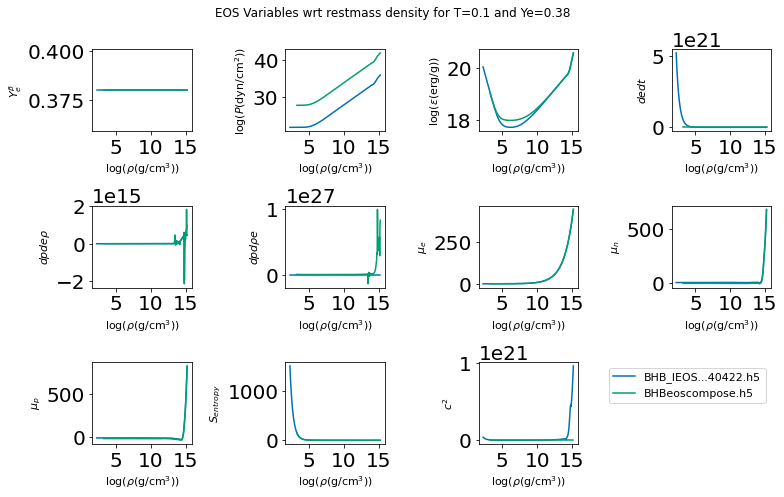

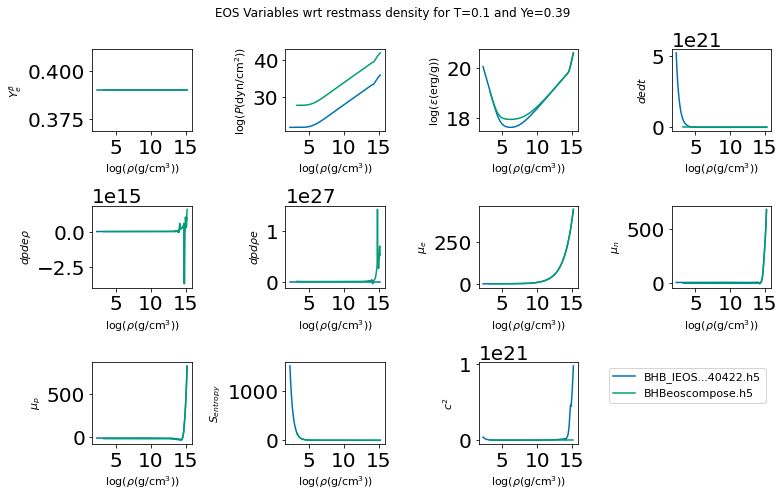

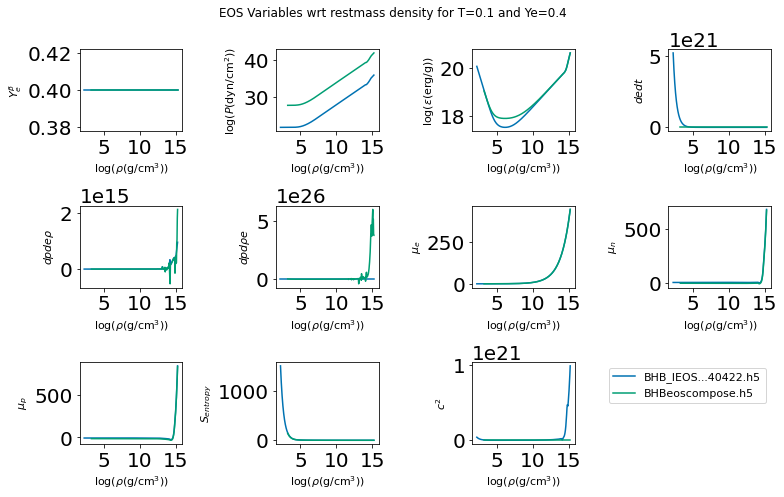

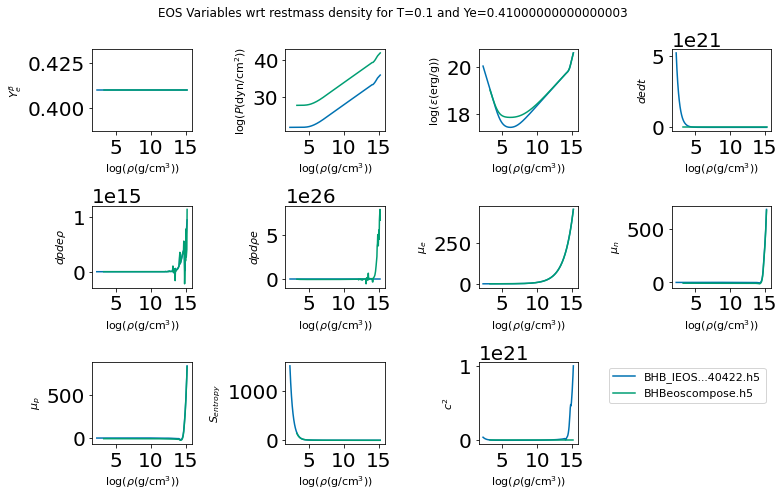

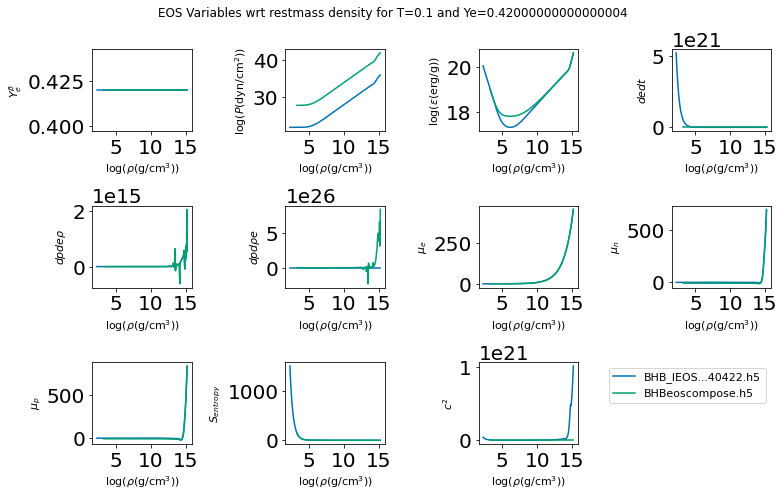

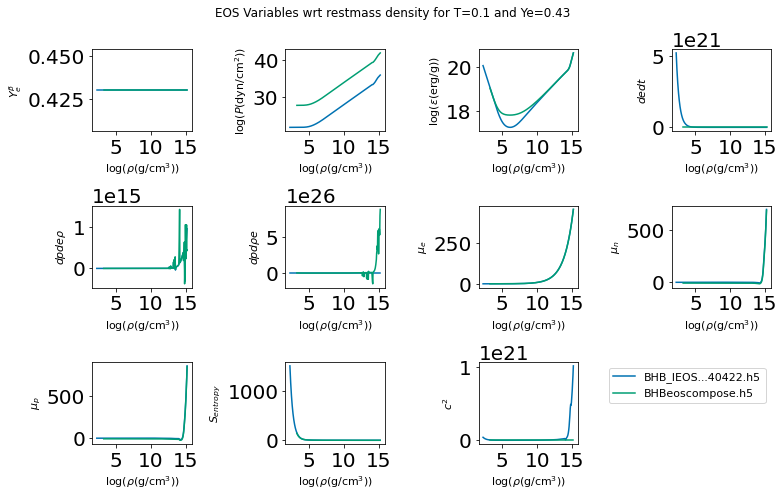

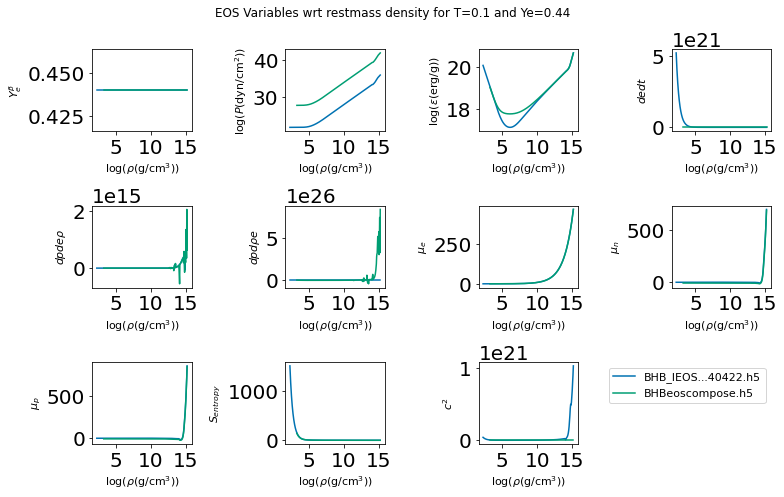

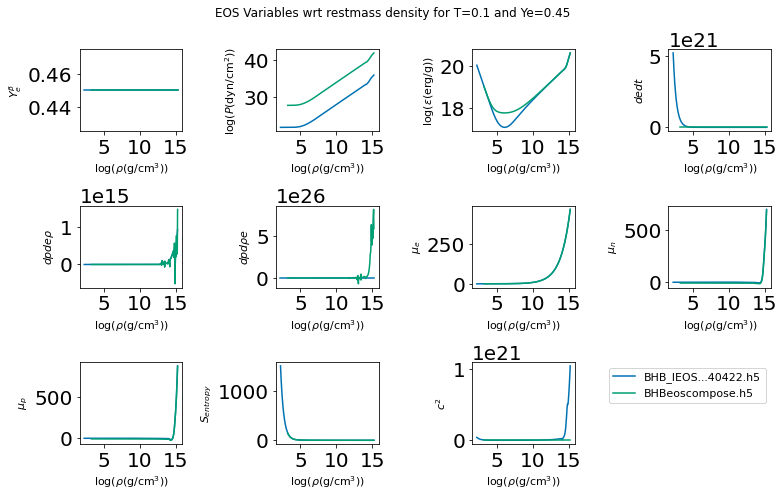

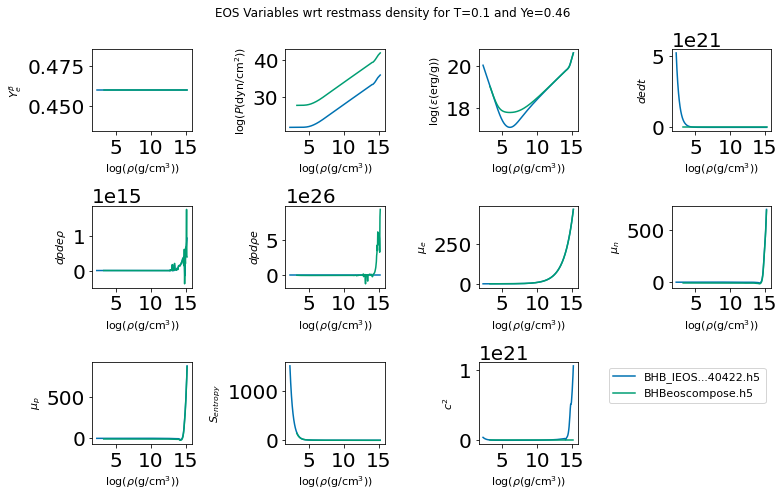

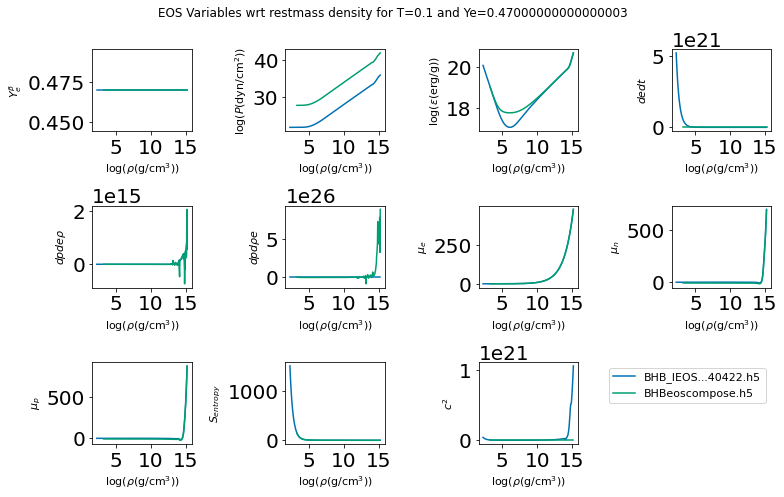

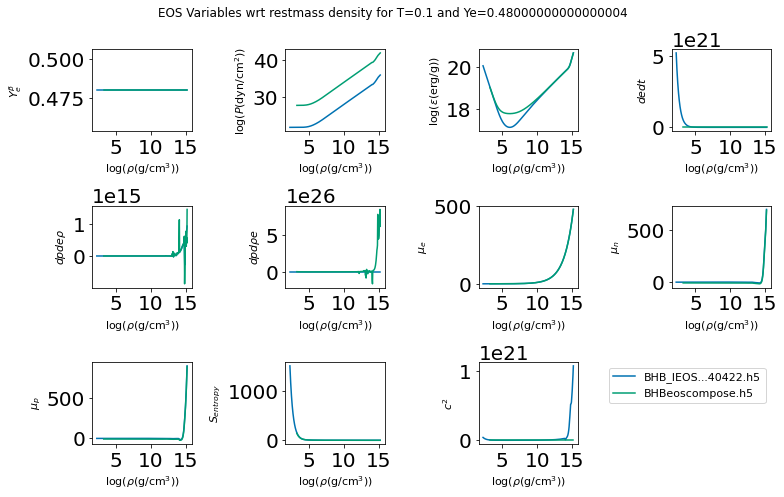

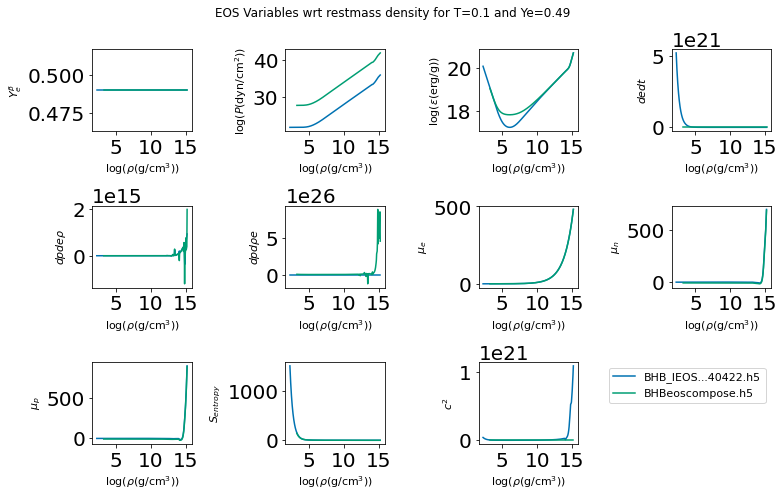

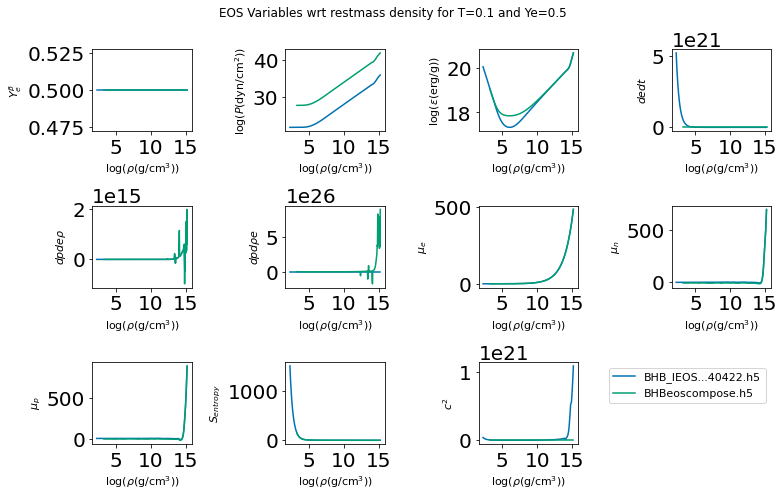

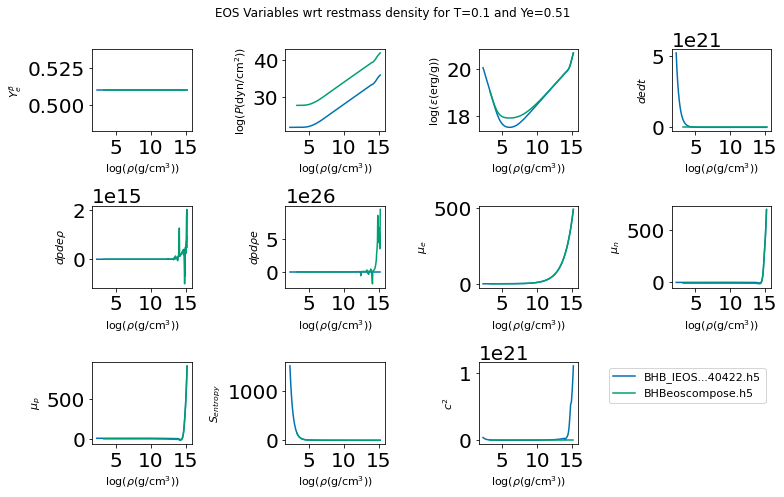

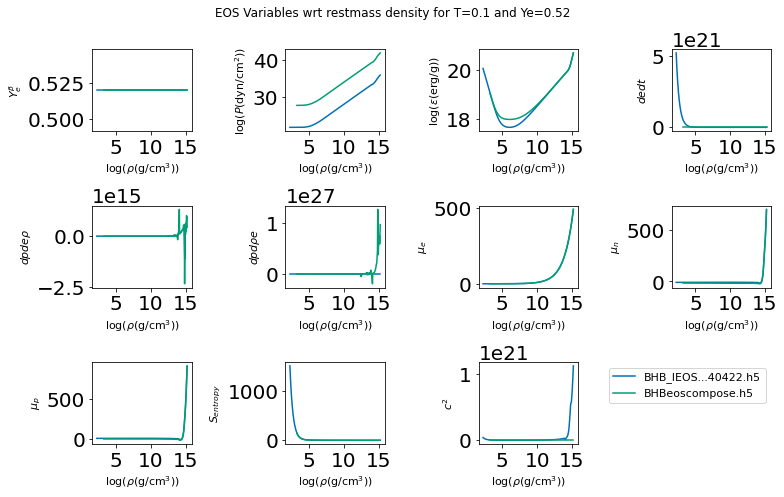

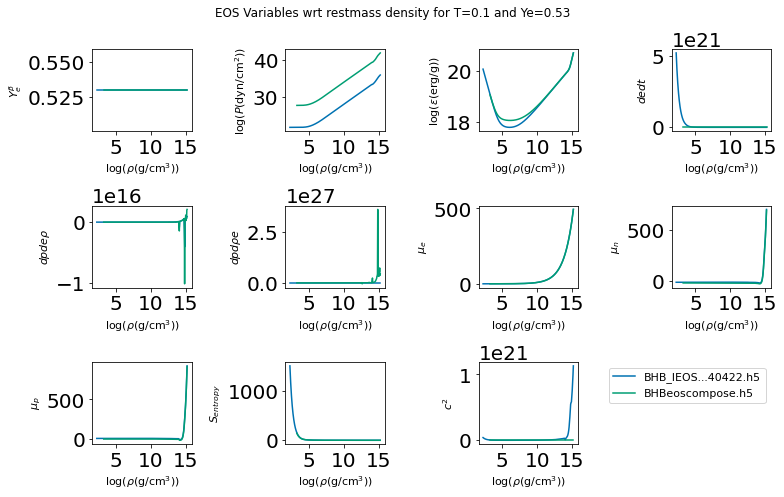

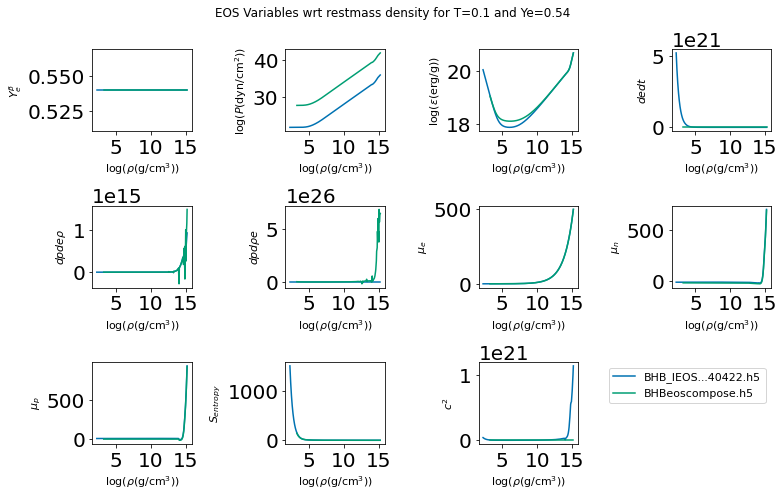

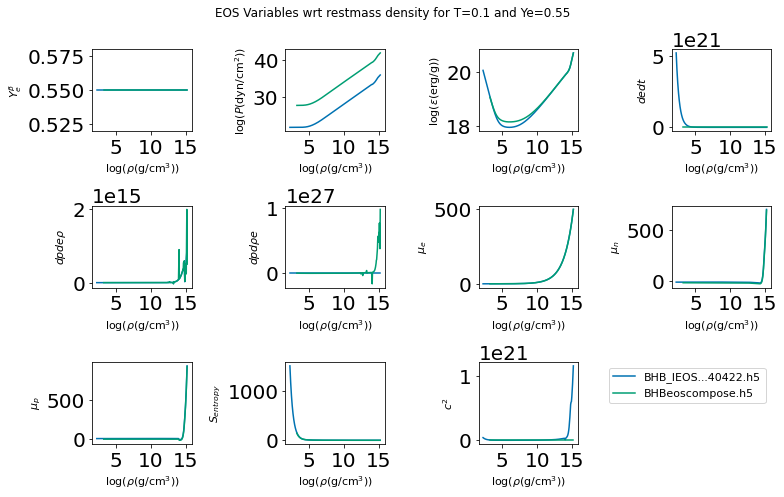

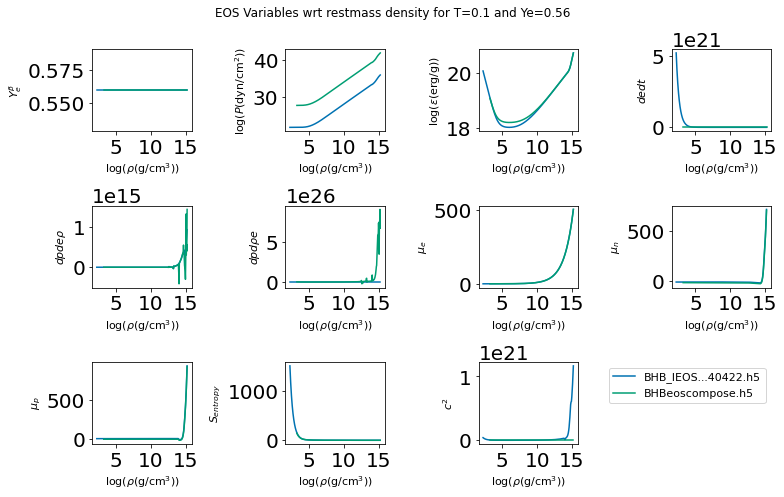

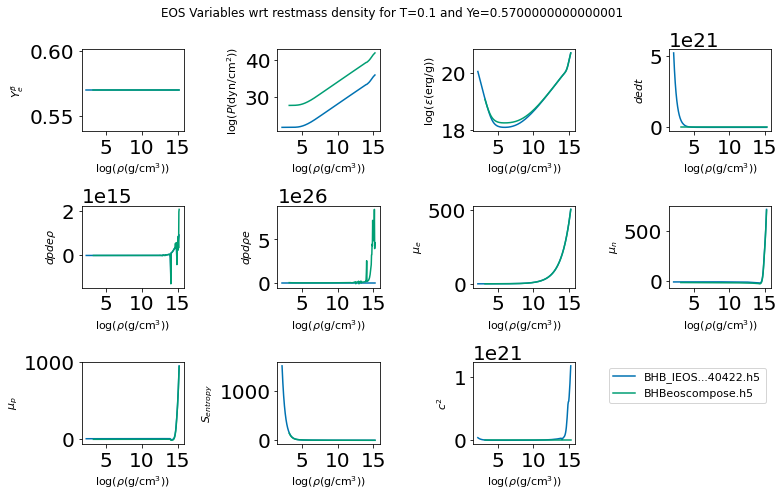

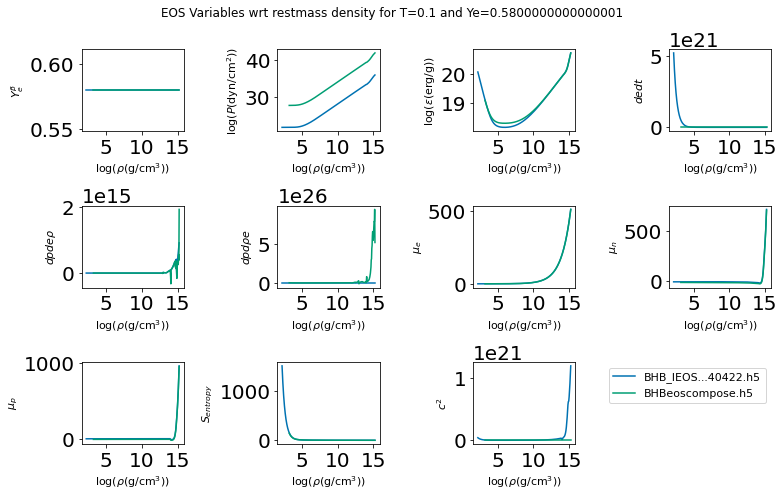

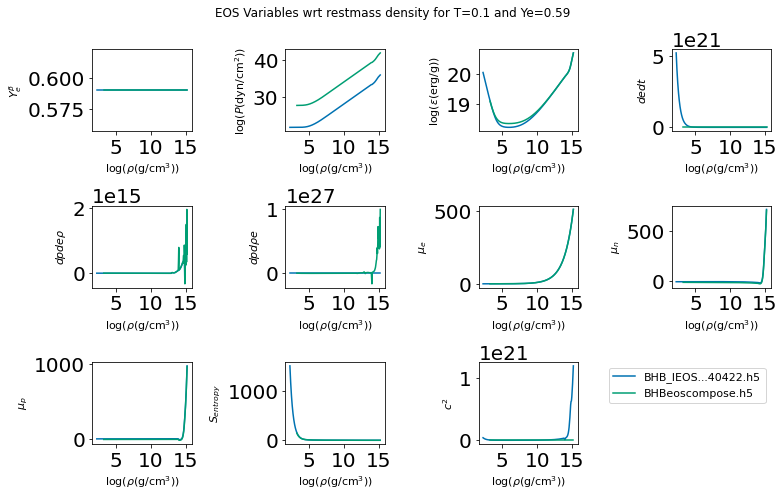

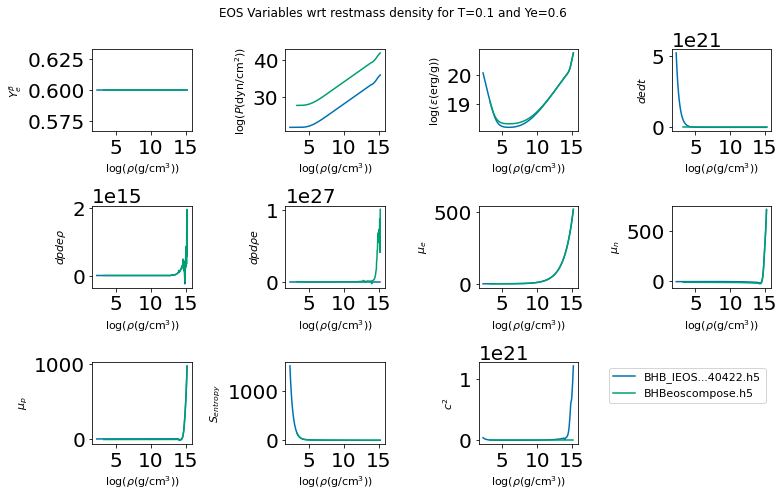

In [60]:

EOS_dict2 = {}
temp = 10**min(logtemp_list2)
for ye in ye_list2:
    fig2, logrho2, dpderho2, dpdrhoe2, cs2_2 = plot_EOS(['BHB_lEOS_rho234_temp180_ye60_version_102_20140422.h5','BHBeoscompose.h5'],ye=ye,T=temp,verbose=False)
    if  min(dpderho2)<-0.1 or min(dpdrhoe2)<-0.1 or min(cs2_2)<-0.1:
        fig2.savefig('BHB_intrinsic_ye_Tmin_'+str(ye)+'.png')
        EOS_dict2[str(ye)] = [fig2, logrho2, dpderho2, dpdrhoe2, cs2_2]

In [12]:
logrho = EOS_dict['0.031'][1].copy()
dpderho = EOS_dict['0.031'][2].copy()
len(EOS_dict)

51

In [13]:
slope = []
for i, j in enumerate(dpderho):
    if i == len(dpderho)-1:
        break      
    else: slope.append(np.abs(dpderho[i+1]-j))

print(max(slope), slope.index(max(slope)))


2.94322631149348e+16 211


In [47]:
def smooth(var, window_size):
    slope = []
    for i, j in enumerate(var):
        if i == len(var)-1:
            break      
        else: slope.append(np.abs(var[i+1]-j))
            
    maxim = max(slope) 
    max_ind = slope.index(max(slope))
    peak_indices = range(max_ind-window_size, max_ind+window_size)
    for i in peak_indices:
        var[i] = (var[i-(window_size+2)]+var[i+(window_size+2)])/2
    return var

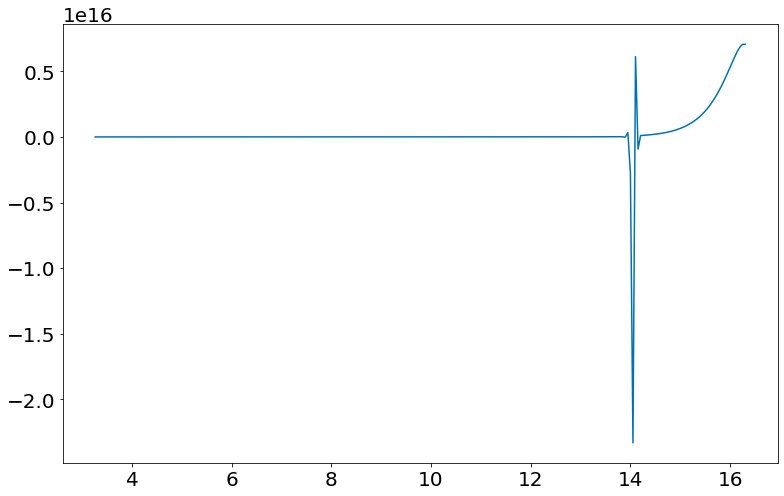

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(11,7), tight_layout=True)
ax.plot(logrho, dpderho)


In [25]:
smooth(dpderho)

IndexError: list index out of range

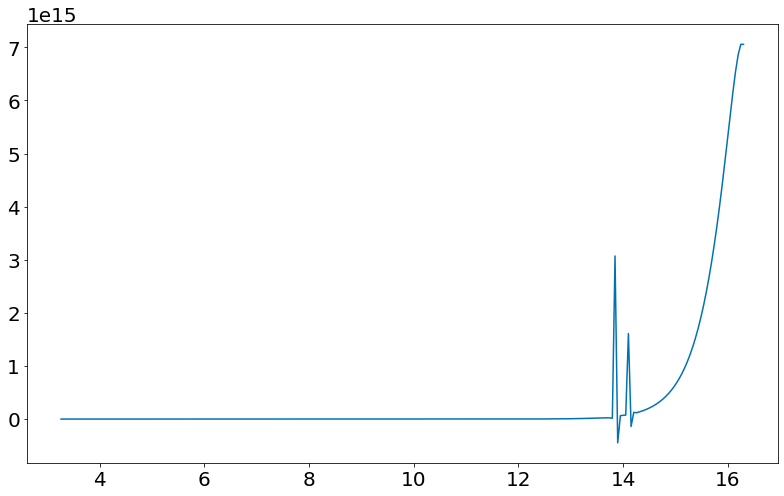

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(11,7), tight_layout=True)
ax.plot(logrho, dpderho)

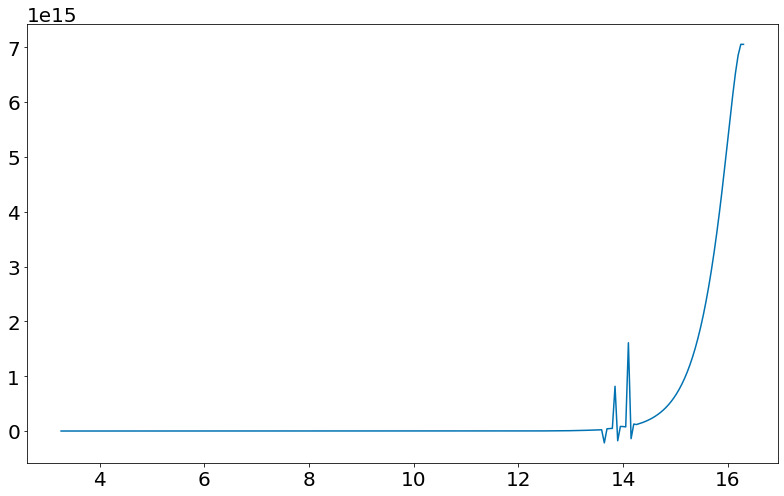

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(11,7), tight_layout=True)
ax.plot(logrho, dpderho)

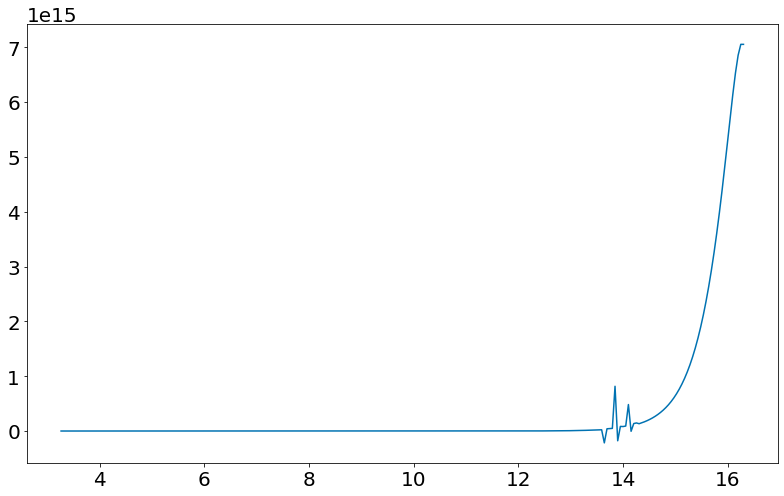

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(11,7), tight_layout=True)
ax.plot(logrho, dpderho)

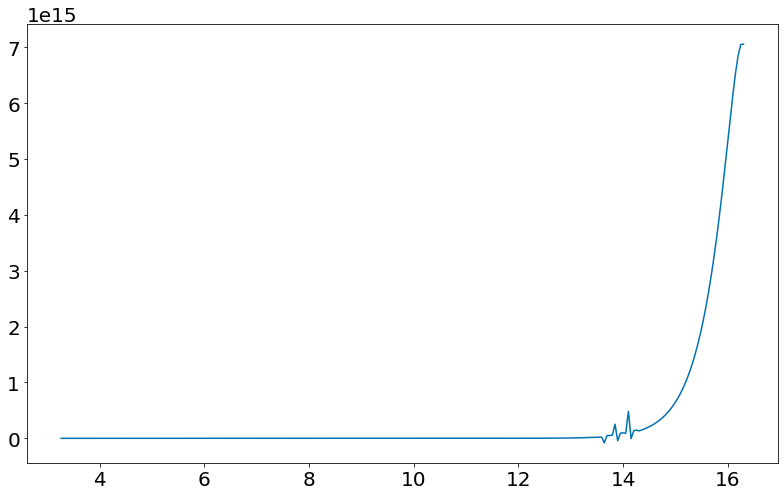

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(11,7), tight_layout=True)
ax.plot(logrho, dpderho)

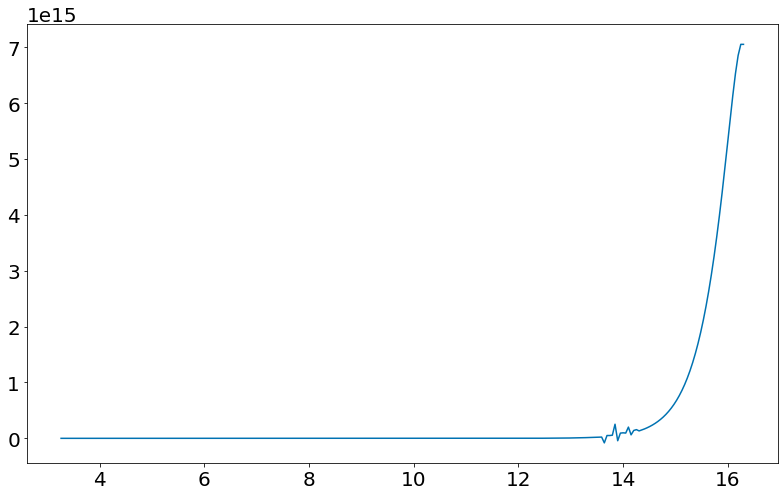

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(11,7), tight_layout=True)
ax.plot(logrho, dpderho)

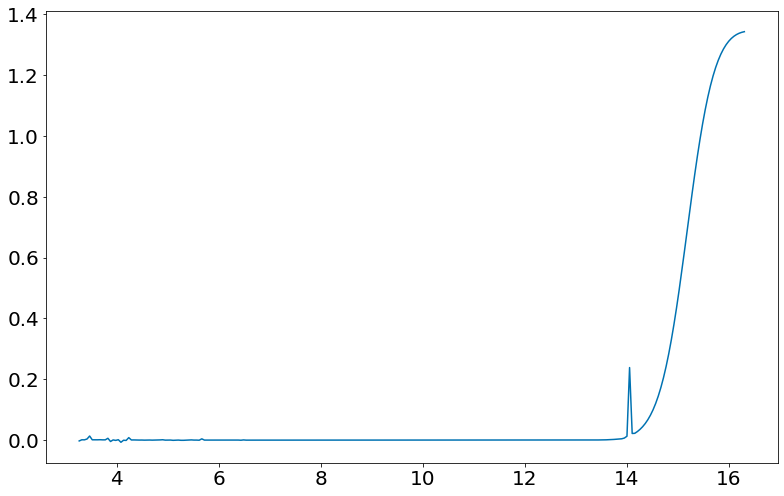

In [48]:
cs2 = EOS_dict['0.031'][4].copy()

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(11,7), tight_layout=True)
ax.plot(logrho, cs2)

In [49]:
smooth(cs2, 4) # shouldnt the speed of sound always be positive?

[-0.0026388022992933006,
 0.0011558070125706674,
 0.0009520674519006349,
 0.0037007235200118434,
 0.013509983636310728,
 0.001099662871465903,
 0.0009533058262635611,
 0.0010659851545829068,
 0.0013445755313813178,
 0.0009253627580521956,
 0.0009621098227122308,
 0.006088263009992462,
 -0.004487571446665391,
 0.0006489709118959672,
 -0.0008527349349532538,
 0.001393047637803007,
 -0.00703185712374363,
 -0.00037207596134020767,
 -0.0009655273398640531,
 0.008203170107145831,
 0.0004955465591455554,
 0.0006342812897912943,
 0.00030894819644730875,
 0.00019499945444733855,
 0.00028240265809318976,
 -2.3355898119088162e-05,
 0.00019536580215776304,
 0.0003180746124681038,
 -4.062417287323412e-06,
 0.00020826650346105732,
 0.00022923857425896416,
 0.0007037865206728403,
 0.0012665037395222561,
 2.7414191745007107e-07,
 0.00021606136562629232,
 0.0002389268019191698,
 -0.0006378621524934402,
 -0.00023563432295420383,
 0.00017093586145544386,
 -0.0005423246322669572,
 -0.0005377075326948328,


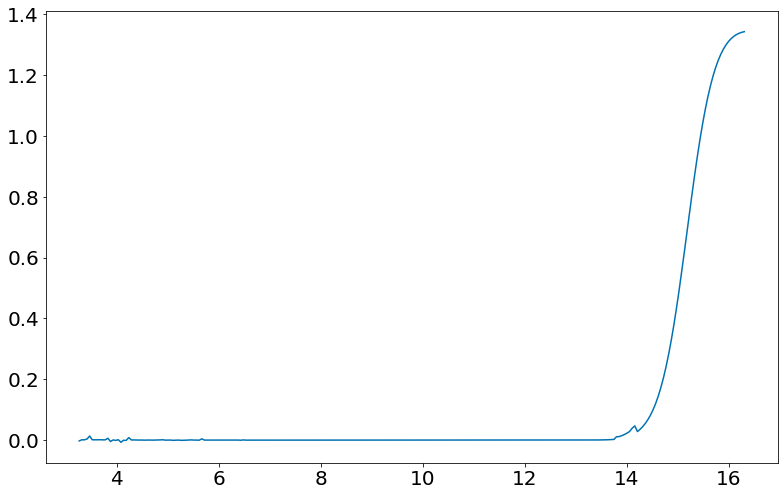

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(11,7), tight_layout=True)
ax.plot(logrho, cs2)

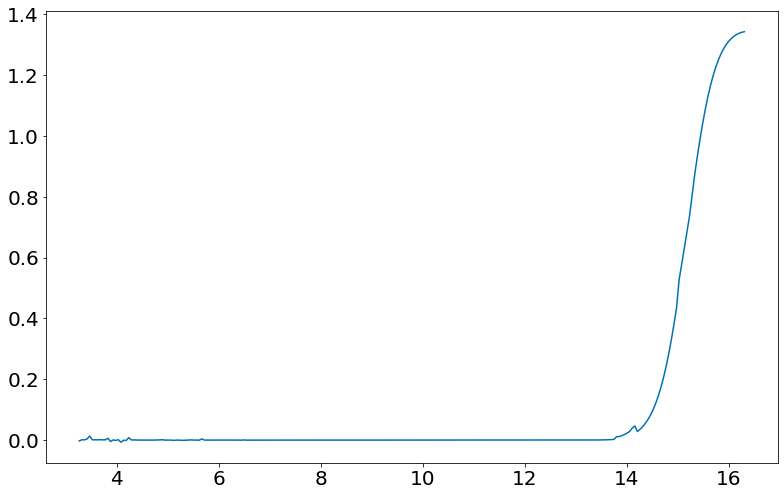

In [51]:
smooth(cs2, 3)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(11,7), tight_layout=True)
ax.plot(logrho, cs2)

In [45]:
smooth(cs2, 4)

[-0.0026388022992933006,
 0.0011558070125706674,
 0.0009520674519006349,
 0.0037007235200118434,
 0.013509983636310728,
 0.001099662871465903,
 0.0009533058262635611,
 0.0010659851545829068,
 0.0013445755313813178,
 0.0009253627580521956,
 0.0009621098227122308,
 0.006088263009992462,
 -0.004487571446665391,
 0.0006489709118959672,
 -0.0008527349349532538,
 0.001393047637803007,
 -0.00703185712374363,
 -0.00037207596134020767,
 -0.0009655273398640531,
 0.008203170107145831,
 0.0004955465591455554,
 0.0006342812897912943,
 0.00030894819644730875,
 0.00019499945444733855,
 0.00028240265809318976,
 -2.3355898119088162e-05,
 0.00019536580215776304,
 0.0003180746124681038,
 -4.062417287323412e-06,
 0.00020826650346105732,
 0.00022923857425896416,
 0.0007037865206728403,
 0.0012665037395222561,
 2.7414191745007107e-07,
 0.00021606136562629232,
 0.0002389268019191698,
 -0.0006378621524934402,
 -0.00023563432295420383,
 0.00017093586145544386,
 -0.0005423246322669572,
 -0.0005377075326948328,


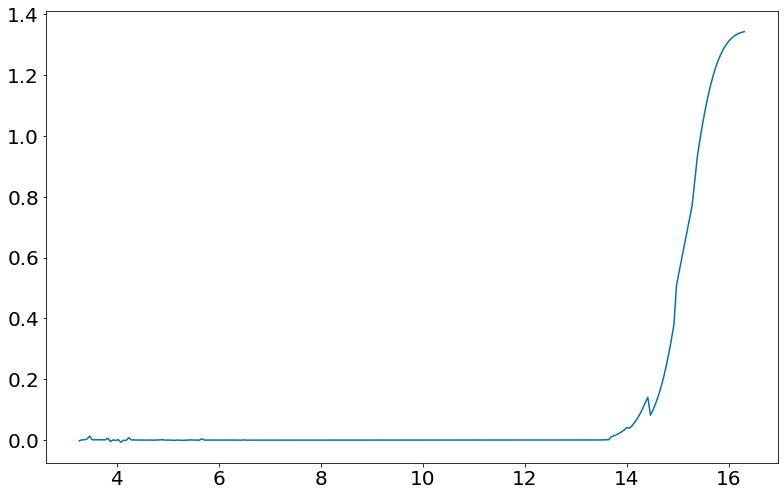

In [46]:

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(11,7), tight_layout=True)
ax.plot(logrho, cs2)

In [ ]:
plot_EOS(filenames, ye, T=0.105,verbose=False, beta=False, dpderho_CO=[], dpdrhoe_CO=[], cs2_CO=[])